<a href="https://colab.research.google.com/github/CristinaTeixido/Heart-Disease-prediction/blob/main/heartdisease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PROJECT AA1**: Laia Royo Rion and Cristina Teixidó Cruïlles

In [ ]:
import numpy as np
from sklearn.model_selection import cross_val_predict, cross_val_score
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
import pandas as pd
from tabulate import tabulate
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import scale
from sklearn.linear_model import LogisticRegression, Perceptron, LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor, KNeighborsRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import preprocessing
from pandas.plotting import scatter_matrix
from scipy.stats import boxcox, chi2_contingency, pearsonr
from statsmodels.genmod.generalized_linear_model import GLM
from sklearn.metrics import classification_report,  f1_score, roc_curve, auc, r2_score, classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, mean_squared_error, median_absolute_error, mean_absolute_error, calinski_harabasz_score, silhouette_score, davies_bouldin_score
import graphviz
from sklearn.tree import export_graphviz, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,GradientBoostingClassifier,StackingClassifier,ExtraTreesClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split,  KFold, cross_val_score, RepeatedKFold
from sklearn.naive_bayes import GaussianNB
from time import time
from datetime import timedelta
from sklearn.svm import LinearSVR, SVR, SVC
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from numpy.random import  uniform,normal, multivariate_normal
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import minmax_scale, StandardScaler
from IPython.core.interactiveshell import InteractiveShell
import warnings

warnings.filterwarnings("ignore")
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.precision', 3)

First, we will load the dataset and look for its characteristics.

In [ ]:
Data = pd.read_csv("heart.csv", header=0, delimiter=',')
Data.shape
Data['target'].value_counts()

(919, 12)

target
1    508
0    411
Name: count, dtype: int64

We have 919 observations and 11 attributes (categorical or numerical) plus the target. Also, target is balanced as we see in the last line because the number of ones and zeros is approximatly the same.

In [ ]:
Data.describe(include='all')

age  sex      cpt   restBP     chol   fastBS restecg    maxHR  \
count   919.000  919  919.000  919.000  919.000  919.000     919  919.000   
unique      NaN    2      NaN      NaN      NaN      NaN       3      NaN   
top         NaN    M      NaN      NaN      NaN      NaN  Normal      NaN   
freq        NaN  726      NaN      NaN      NaN      NaN     553      NaN   
mean     53.469  NaN    3.251  132.372  198.714    0.233     NaN  142.427   
std       9.513  NaN    0.931   18.519  109.355    0.423     NaN   73.970   
min      15.000  NaN    1.000    0.000    0.000    0.000     NaN   60.000   
25%      47.000  NaN    3.000  120.000  173.000    0.000     NaN  120.000   
50%      54.000  NaN    4.000  130.000  223.000    0.000     NaN  138.000   
75%      60.000  NaN    4.000  140.000  267.000    0.000     NaN  156.000   
max      77.000  NaN    4.000  200.000  603.000    1.000     NaN  999.000   

          exang  oldpeak slope   target  
count   919.000  919.000   919  919.000  
unique      NaN      NaN     3      NaN  
top         NaN      NaN  Flat      NaN  
freq        NaN      NaN   460      NaN  
mean      0.404    0.886   NaN    0.553  
std       0.491    1.066   NaN    0.497  
min       0.000   -2.600   NaN    0.000  
25%       0.000    0.000   NaN    0.000  
50%       0.000    0.600   NaN    1.000  
75%       1.000    1.500   NaN    1.000  
max       1.000    6.200   NaN    1.000

In this first contact with attributes we notice some problems on the dataset:
*   In age we observe a minimum strange value = 15 because as we have read about the dataset, observations come from adults older than 25.
*   Cpt, fastBS and exang are categorical attributes and should be considered as it.
*   In restBP and chol there are som values equal to zero which is not a possible value for those attribute and seem to be missing values.
*   MaxHR has a max value too big.
*   To many atributtes don't follow a normal distribution.

For those reasons the study of each attribute is necessary. There, we would try to identify possible missing values or outliers and to achive a gaussian distribution for each feature. But before we would set cpt, exang and fastBPS as categorical attributes.

In [ ]:
Data.cpt = Data.cpt.astype('object')
Data.fastBS = Data.fastBS.astype('object')
Data.exang = Data.exang.astype('object')
Data.target = Data.target.astype('object')
Data['exang'] = Data['exang'].replace([0, 1], ['noexang', 'exang'])
Data['cpt'] = Data['cpt'].replace([1, 2, 3, 4], ['t_angina', 'a_angina', 'non_angina', 'assymptomatic'])
Data['fastBS'] = Data['fastBS'].replace([0, 1], ['low_fastBS', 'high_fastBS'])
Data.dtypes

age          int64
sex         object
cpt         object
restBP       int64
chol         int64
fastBS      object
restecg     object
maxHR        int64
exang       object
oldpeak    float64
slope       object
target      object
dtype: object

We create a matrix named X, with all the parameters and a column y with the results of the target.

In [ ]:
X = Data[['age','sex', 'cpt','restBP', 'chol', 'fastBS', 'restecg', 'maxHR', 'exang', 'oldpeak', 'slope']].to_numpy()
y = Data[['target']].to_numpy()

print(X.shape, y.shape)

(919, 11) (919, 1)


We split the data in the train part (75% of the data) and the test part (25% of the data).

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(689, 11) (689, 1)
(230, 11) (230, 1)


In the next part (preprocessing), we will use the X_train as a Dataframe and not a matrix, so in this part we convert the matrix to a dataframe named Data.

In [ ]:
feature_columns = ['age','sex', 'cpt','restBP', 'chol', 'fastBS', 'restecg', 'maxHR', 'exang', 'oldpeak', 'slope']
target_column = ['target']

X_df = pd.DataFrame(X_train, columns=feature_columns)

y_df = pd.DataFrame(y_train, columns=target_column)

Data = pd.concat([X_df, y_df], axis=1)

Data.age = Data.age.astype('int64')
Data.restBP = Data.restBP.astype('int64')
Data.chol = Data.chol.astype('int64')
Data.maxHR = Data.maxHR.astype('int64')
Data.oldpeak = Data.oldpeak.astype('float64')

# PREPROCESSING

## Missing values

We want to see if there are some features that are not balanced:

---



In [ ]:
Data.sex.value_counts()
Data.cpt.value_counts()
Data.fastBS.value_counts()
Data.restecg.value_counts()
Data.exang.value_counts()
Data.slope.value_counts()

sex
M    541
F    148
Name: count, dtype: int64

cpt
assymptomatic    367
non_angina       150
a_angina         139
t_angina          33
Name: count, dtype: int64

fastBS
low_fastBS     539
high_fastBS    150
Name: count, dtype: int64

restecg
Normal    410
LVH       140
ST        139
Name: count, dtype: int64

exang
noexang    406
exang      283
Name: count, dtype: int64

slope
Flat    343
Up      296
Down     50
Name: count, dtype: int64

We can observe that many variables are not balanced. For example, we have more samples from man than from woman. This will cause worse predictions.

In cathegorical attributes its not observed any missing value. Let's see the numerical ones.

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'restBP'}>],
       [<Axes: title={'center': 'chol'}>,
        <Axes: title={'center': 'maxHR'}>],
       [<Axes: title={'center': 'oldpeak'}>, <Axes: >]], dtype=object)

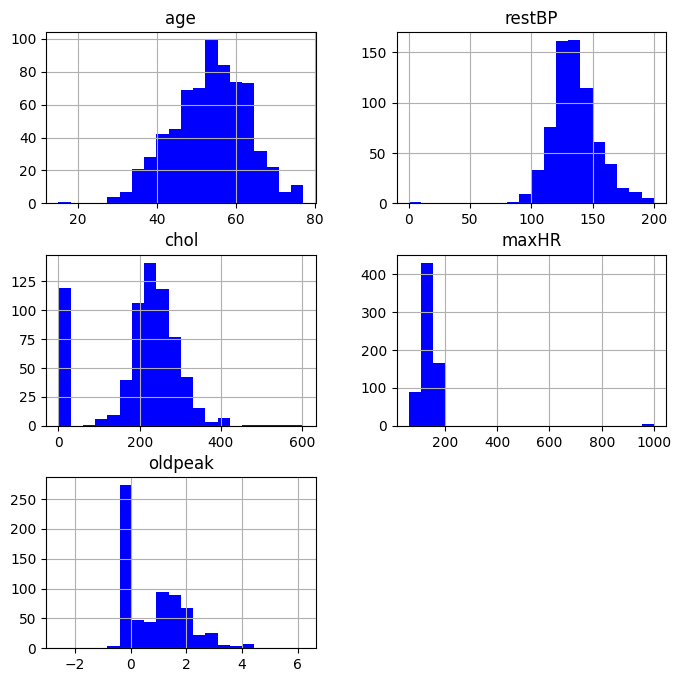

In [ ]:
Data.loc[:,:].hist(bins=20,figsize=(8,8),color='blue')
plt.show()

We observe some outliers or maybe some missing values, its clear we need to study them one by one.

## Restbps

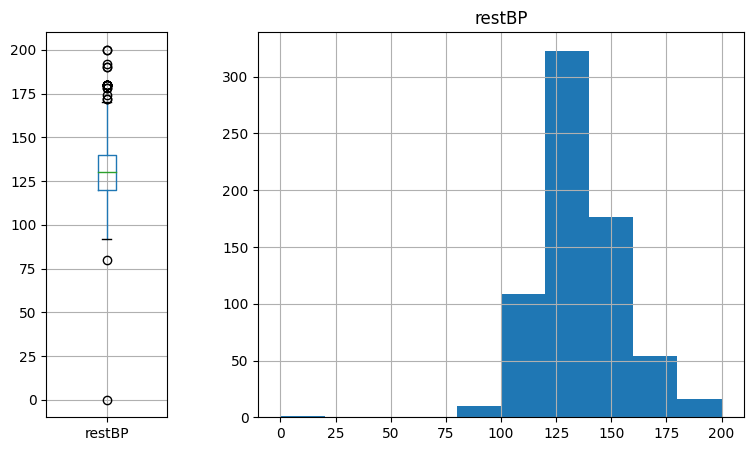

In [ ]:
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
Data.boxplot(column='restBP',ax=axes[0]);
Data.hist(column='restBP', ax=axes[1]);

In [ ]:
(Data.restBP==0).value_counts()
(Data.oldpeak==0).value_counts()

restBP
False    688
True       1
Name: count, dtype: int64

oldpeak
False    418
True     271
Name: count, dtype: int64

As zero is not a possible value in this numerical attribute we will assume that this observation zero is a missing value.

<ipython-input-76-6c7fb81f8270>:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  Data.restBP[Data.restBP == 0] = np.nan
<ipython-input-76-6c7fb81f8270>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

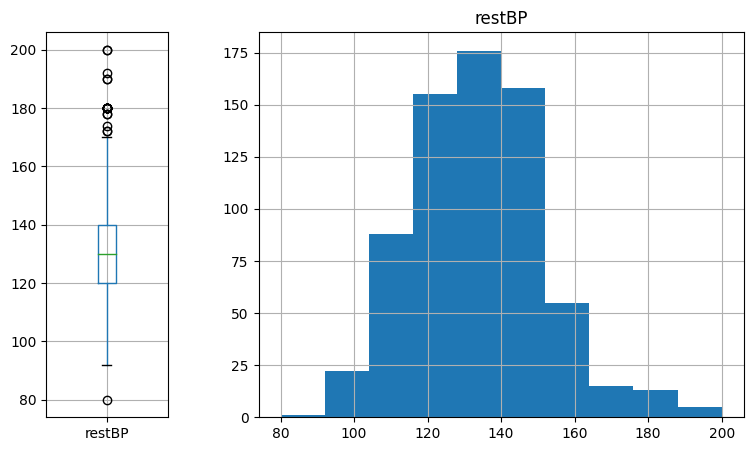

In [ ]:
Data.restBP[Data.restBP == 0] = np.nan
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
Data.boxplot(column='restBP',ax=axes[0]);
Data.hist(column='restBP', ax=axes[1]);

## Cholesterol


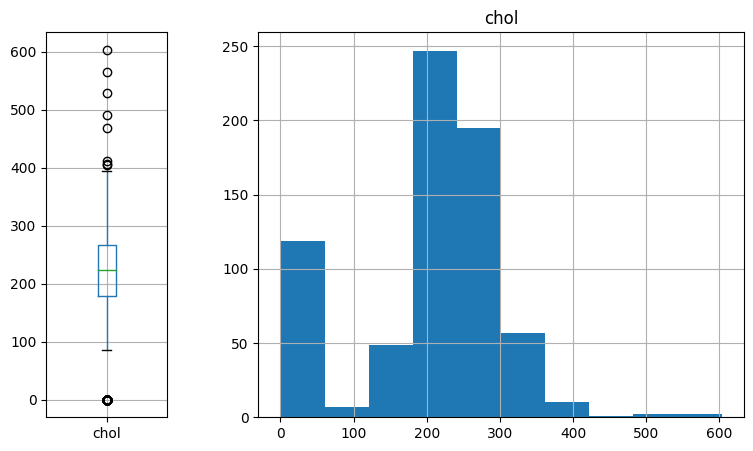

In [ ]:
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
Data.boxplot(column='chol',ax=axes[0]);
Data.hist(column='chol', ax=axes[1]);

Cholesterol attribute has too many missing values set as zero:

In [ ]:
Data.chol.count()
(Data.chol==0).value_counts()

689

chol
False    570
True     119
Name: count, dtype: int64

<ipython-input-79-4233c6ce72f0>:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  Data.chol[Data.chol == 0] = np.nan
<ipython-input-79-4233c6ce72f0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

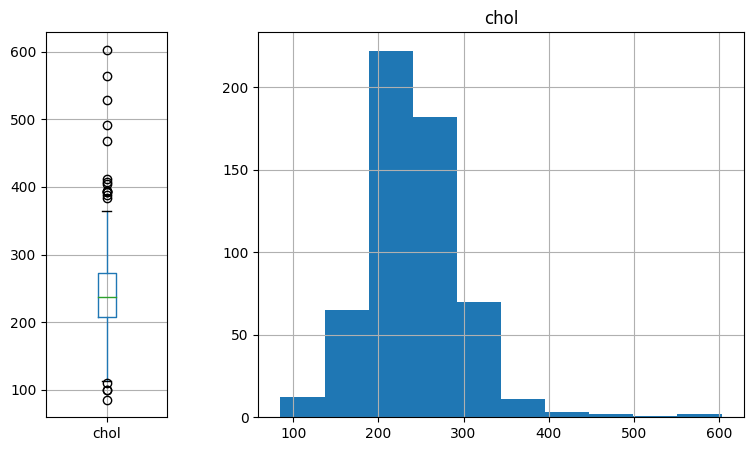

In [ ]:
Data.chol[Data.chol == 0] = np.nan
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
Data.boxplot(column='chol',ax=axes[0]);
Data.hist(column='chol', ax=axes[1]);

## MaxHR

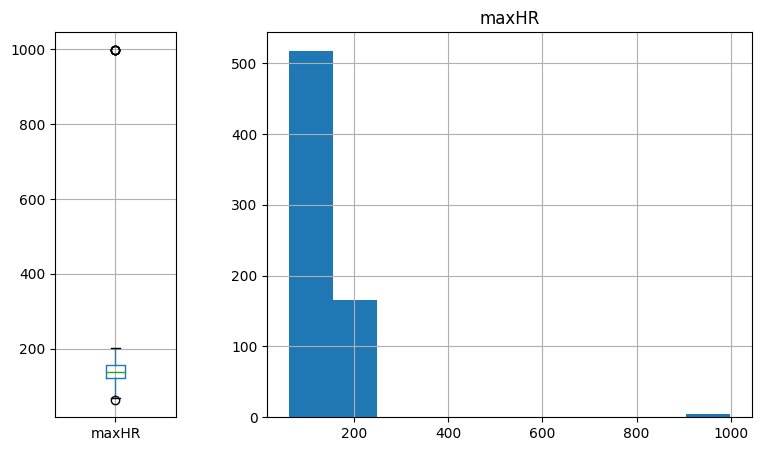

In [ ]:
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
Data.boxplot(column='maxHR',ax=axes[0]);
Data.hist(column='maxHR', ax=axes[1]);

It appears an outlier set to 999. We will set it to nan.

<ipython-input-81-9d0c5b6ad86f>:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  Data.maxHR[Data.maxHR == 999] = np.nan
<ipython-input-81-9d0c5b6ad86f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

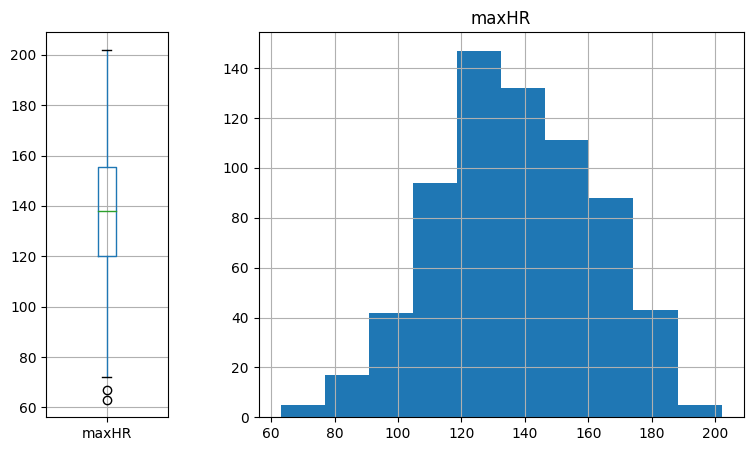

In [ ]:
Data.maxHR[Data.maxHR == 999] = np.nan
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
Data.boxplot(column='maxHR',ax=axes[0]);
Data.hist(column='maxHR', ax=axes[1]);

## Oldpeak

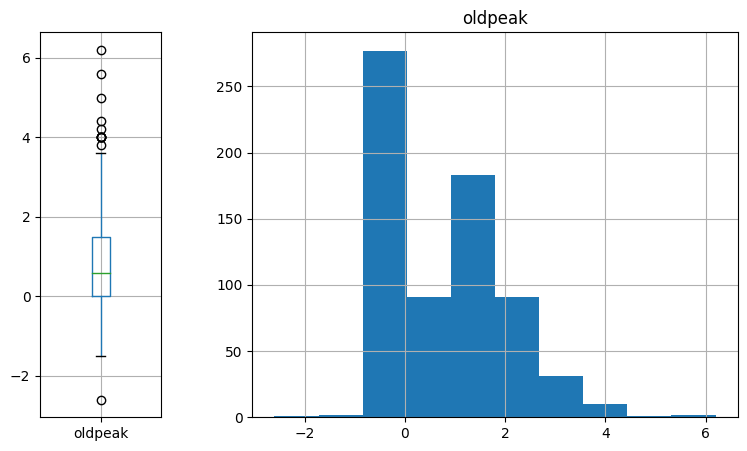

In [ ]:
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
Data.boxplot(column='oldpeak',ax=axes[0]);
Data.hist(column='oldpeak', ax=axes[1]);

It's seen that there are a lot of values equal to zero but in this case we assume that are correct values because of the meaning of the attribute; 0 means that the patient has a "normal" oldpeak.

In [ ]:
Data.isna().value_counts()

age    sex    cpt    restBP  chol   fastBS  restecg  maxHR  exang  oldpeak  slope  target
False  False  False  False   False  False   False    False  False  False    False  False     566
                             True   False   False    False  False  False    False  False     117
                             False  False   False    True   False  False    False  False       4
                             True   False   False    True   False  False    False  False       1
                     True    True   False   False    False  False  False    False  False       1
Name: count, dtype: int64

Columns with missing values are: Restbps, chol and maxHR. Due to the similarity and the size of data, we decide to apply imputation with 1NN method. This method consists in copying the new value from the most similar observation.

We need to change the categorical variables, so we convert categorical features to dummy variables.

In [ ]:
Old_data = Data

#Sex
sex = pd.get_dummies(Data['sex'], drop_first=True)

#Cpt
cpt = pd.get_dummies(Data['cpt'], drop_first=True)

#FastBS
fastbs = pd.get_dummies(Data['fastBS'], drop_first=True)

#Restecg
restecg = pd.get_dummies(Data['restecg'], drop_first=True)

#Exang
exang = pd.get_dummies(Data['exang'], drop_first=True)

#Slope
slope = pd.get_dummies(Data['slope'], drop_first=True)

We replace the columns with the dummies

In [ ]:
Data.drop(['sex', 'cpt', 'fastBS', 'restecg', 'exang', 'slope'], axis=1, inplace=True)
Data = pd.concat([Data, sex, cpt, fastbs, restecg, exang, slope], axis=1)
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 689 entries, 0 to 688
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            689 non-null    int64  
 1   restBP         688 non-null    float64
 2   chol           570 non-null    float64
 3   maxHR          684 non-null    float64
 4   oldpeak        689 non-null    float64
 5   target         689 non-null    object 
 6   M              689 non-null    bool   
 7   assymptomatic  689 non-null    bool   
 8   non_angina     689 non-null    bool   
 9   t_angina       689 non-null    bool   
 10  low_fastBS     689 non-null    bool   
 11  Normal         689 non-null    bool   
 12  ST             689 non-null    bool   
 13  noexang        689 non-null    bool   
 14  Flat           689 non-null    bool   
 15  Up             689 non-null    bool   
dtypes: bool(10), float64(4), int64(1), object(1)
memory usage: 39.2+ KB


In [ ]:
subset_of_data = Data.drop(columns=['maxHR','chol','restBP'])
Data = Data.apply(pd.to_numeric)
rows_not_missing = Data.restBP.notna() & Data.chol.notna() & Data.maxHR.notna() & Data.age.notna()
data_without_missings = subset_of_data[rows_not_missing]

In [ ]:
data_restbp_nans = subset_of_data[Data.restBP.isna()]
data_chol_nans = subset_of_data[Data.chol.isna()]
data_maxHR_nans = subset_of_data[Data.maxHR.isna()]

#restbp
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(data_without_missings, Data.restBP[rows_not_missing])
knn_r = knn.predict(data_restbp_nans);

#chol
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(data_without_missings, Data.chol[rows_not_missing])
knn_c = knn.predict(data_chol_nans);

#maxHR
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(data_without_missings, Data.maxHR[rows_not_missing])
knn_m = knn.predict(data_maxHR_nans);

In [ ]:
Data.restBP[Data.restBP.isna()] = knn_r
Data.chol[Data.chol.isna()] = knn_c
Data.maxHR[Data.maxHR.isna()] = knn_m

<ipython-input-88-1620f33b95af>:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  Data.restBP[Data.restBP.isna()] = knn_r
<ipython-input-88-1620f33b95af>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

In [ ]:
Data.isna().value_counts()

age    restBP  chol   maxHR  oldpeak  target  M      assymptomatic  non_angina  t_angina  low_fastBS  Normal  ST     noexang  Flat   Up   
False  False   False  False  False    False   False  False          False       False     False       False   False  False    False  False    689
Name: count, dtype: int64

## Outliers

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'restBP'}>],
       [<Axes: title={'center': 'chol'}>,
        <Axes: title={'center': 'maxHR'}>],
       [<Axes: title={'center': 'oldpeak'}>, <Axes: >]], dtype=object)

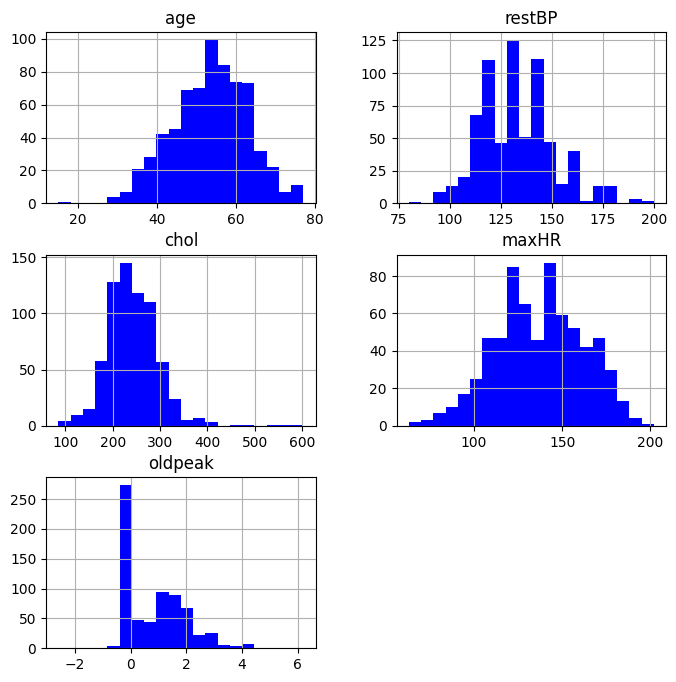

In [ ]:
Data.loc[:,"age":"oldpeak"].hist(bins=20,figsize=(8,8),color='blue')
plt.show()

There is an outlier in age, a value lower than 25.

In [ ]:
Data = Data[Data['age']>25]

Local Outlier Factor

In [ ]:
local_outlier_factor = LocalOutlierFactor(n_neighbors=30)
result = local_outlier_factor.fit_predict(Data['chol'].values.reshape(-1, 1))

outliers = result == -1
no_outliers = result == 1

Counter(result)

Counter({1: 654, -1: 34})

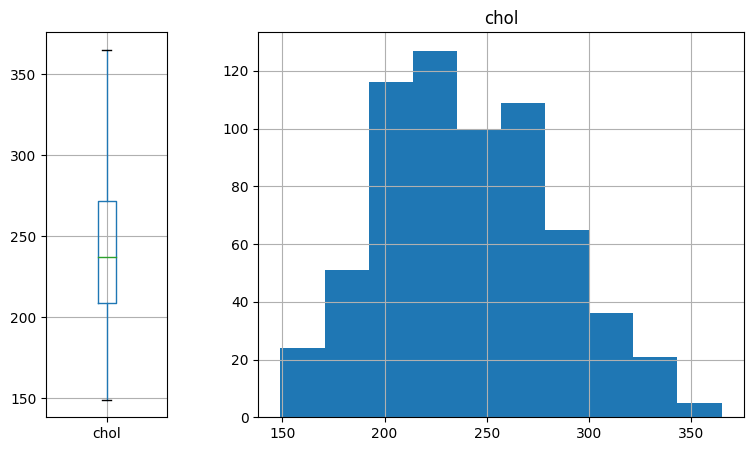

In [ ]:
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
Data[no_outliers].boxplot(column='chol',ax=axes[0]);
Data[no_outliers].hist(column='chol', ax=axes[1]);

In [ ]:
Data.drop(Data.index[outliers], inplace=True)

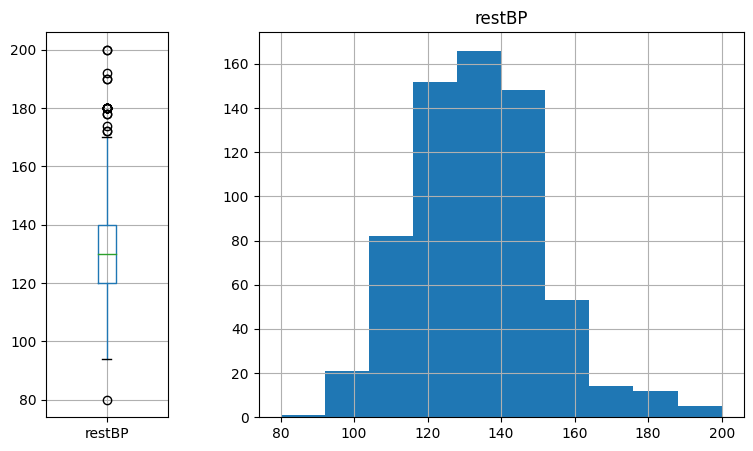

In [ ]:
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
Data.boxplot(column='restBP',ax=axes[0]);
Data.hist(column='restBP', ax=axes[1]);

In [ ]:
local_outlier_factor = LocalOutlierFactor(n_neighbors=30)
result = local_outlier_factor.fit_predict(Data['restBP'].values.reshape(-1, 1))

outliers = result == -1
no_outliers = result == 1

Counter(result)

Counter({1: 495, -1: 159})

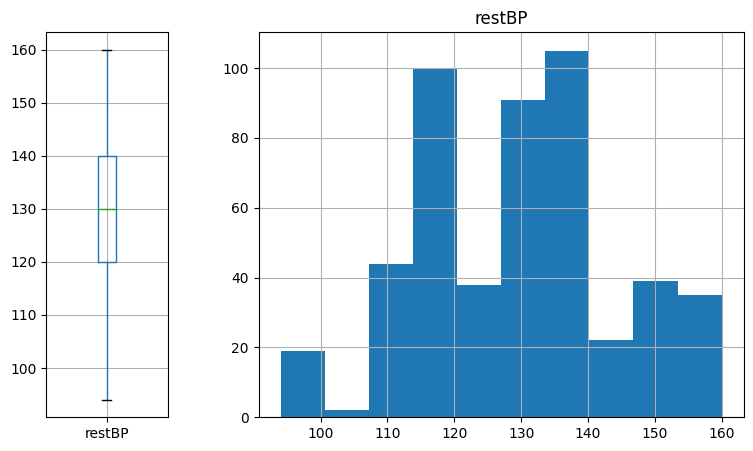

In [ ]:
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
Data[no_outliers].boxplot(column='restBP',ax=axes[0]);
Data[no_outliers].hist(column='restBP', ax=axes[1]);

In [ ]:
Data.drop(Data.index[outliers], inplace=True)

Finally, we want to have gaussianity in our numerical attributes.

In [ ]:
for x in ['age', 'restBP', 'chol', 'maxHR']:
  y, _= boxcox(Data[x])
  y = preprocessing.scale(y)
  Data[x] = y

Data['oldpeak'] = preprocessing.scale(Data['oldpeak'])

For each attribute, we will choose the best transformation to aim a distribution similar to normal.

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'restBP'}>],
       [<Axes: title={'center': 'chol'}>,
        <Axes: title={'center': 'maxHR'}>],
       [<Axes: title={'center': 'oldpeak'}>, <Axes: >]], dtype=object)

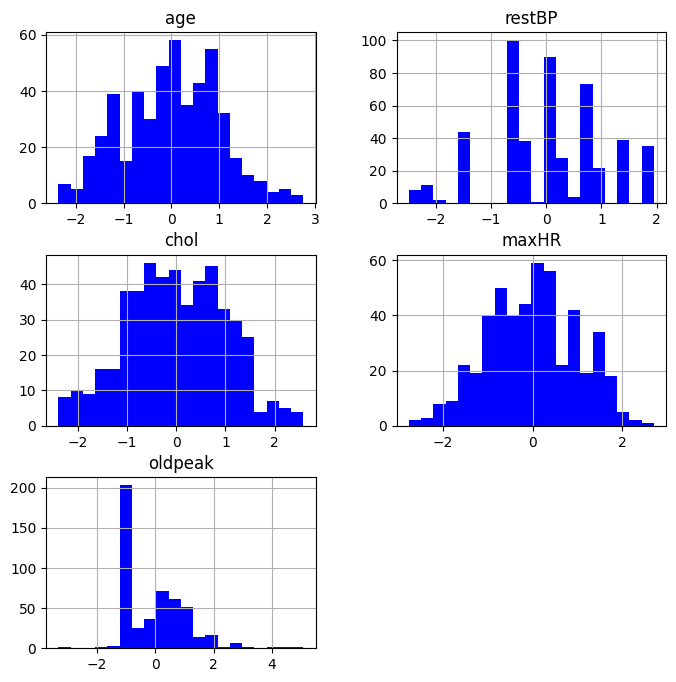

In [ ]:
Data.loc[:,"age":"oldpeak"].hist(bins=20,figsize=(8,8),color='blue')
plt.show()

## Feature selection

For the modeling part, we want to ensure that the variables are independent of each other, and for this reason, we will study the correlation matrix and the VIF of the variables.

<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Correlation Matrix between features')

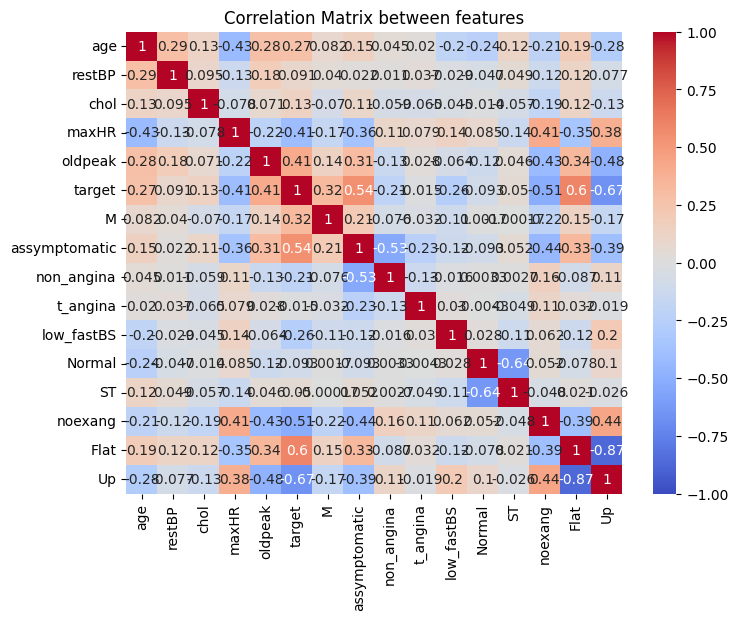

In [ ]:
correlation_matrix = Data.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix between features')
plt.show()

In [ ]:
threshold = 0.6 # maximum correlation between two variables

highly_correlated_features = set()
for i in range(len(correlation_matrix.columns)):
  for j in range(i + 1, len(correlation_matrix.columns)):
    if abs(correlation_matrix.iloc[i, j]) > threshold:
      feature1 = correlation_matrix.columns[i]
      feature2 = correlation_matrix.columns[j]
      highly_correlated_features.add(feature1)
      highly_correlated_features.add(feature2)

print("Highly correlated features:", highly_correlated_features)

Highly correlated features: {'target', 'Up', 'Normal', 'ST', 'Flat'}


Flat and up are highly correlated, which seems logic because they come from the same original atributte. It also happens with Normal and ST.

Now we compute the VIF of the numerical variables:

In [ ]:
numerical_cols = Data.drop('target', axis=1).select_dtypes(include=['float64', 'int64'])

# Càlcul del VIF per a cada variable
vif_data = pd.DataFrame()
vif_data["Variable"] = numerical_cols.columns
vif_data["VIF"] = [variance_inflation_factor(numerical_cols.values, i) for i in range(len(numerical_cols.columns))]

print(vif_data)

  Variable    VIF
0      age  1.361
1   restBP  1.108
2     chol  1.022
3    maxHR  1.242
4  oldpeak  1.114


We can see that all the values are under 5, so we conclude that the variables are not correlated. We can't eliminate any feature.

Now, we will see if variables are correlated with the target.

In [ ]:
correlations_with_target = correlation_matrix['target'].abs().sort_values(ascending=False)
print(correlations_with_target)

target           1.000
Up               0.668
Flat             0.600
assymptomatic    0.541
noexang          0.514
maxHR            0.413
oldpeak          0.408
M                0.319
age              0.268
low_fastBS       0.258
non_angina       0.209
chol             0.134
Normal           0.093
restBP           0.091
ST               0.050
t_angina         0.015
Name: target, dtype: float64


# LINEAR REGRESSION (LASSO AND RIDGE)



We will try linear regression, Ridge cross-validation and Lasso cross-validation and determine which one it has better results.

In [ ]:
X_train = Data[['age','restBP', 'chol', 'maxHR', 'oldpeak','M', 'assymptomatic', 'non_angina', 't_angina', 'low_fastBS', 'Normal', 'ST', 'noexang', 'Flat', 'Up']].to_numpy()
y_train = Data[['target']].to_numpy()

all_lambdas = [1e-10,1e-5,1e-4,1e-3,1e-2,0.1, 0.5, 1, 5, 10, 50, 100]

# do cross-val by hand because OLS does not have 'CV' option..
kf = KFold(n_splits=10, shuffle=True)

# these accumulate scores for each fold, at the end we average
ols_val_score = []
ridge_val_score = [ [] for _ in all_lambdas ]

LINERAR REGRESSION

In [ ]:
cv = KFold(n_splits=10, shuffle=True, random_state=42)
lr = LinearRegression()
lr.fit(X_train,y_train)
folds_r2 = cross_val_score(lr, X_train,y_train, cv=cv, scoring='r2')
y_pred_reg = cross_val_predict(lr, X_train,y_train, cv=cv)
lr_r2 = np.mean(folds_r2)

LinearRegression()

RIDGE CV

In [ ]:
ridge_cv =RidgeCV(alphas=all_lambdas,cv=cv)
ridge_cv.fit(X_train,y_train)
y_pred_ridge = ridge_cv.predict(X_train)

print('Best lambda:', ridge_cv.alpha_, 'R2 score:', ridge_cv.best_score_)

RidgeCV(alphas=[1e-10, 1e-05, 0.0001, 0.001, 0.01, 0.1, 0.5, 1, 5, 10, 50, 100],
        cv=KFold(n_splits=10, random_state=42, shuffle=True))

Best lambda: 10.0 R2 score: 0.5710582299075794


LASSO CV

In [ ]:
y_train = y_train.ravel()
lasso_cv =LassoCV(alphas=all_lambdas,cv=cv)
lasso_cv.fit(X_train,y_train)
y_pred_lasso = lasso_cv.predict(X_train)

lasso_r2 =  np.mean(cross_val_score(lasso_cv, X_train,y_train))

print('Best lambda:', lasso_cv.alpha_, 'R2 score:',lasso_r2)

LassoCV(alphas=[1e-10, 1e-05, 0.0001, 0.001, 0.01, 0.1, 0.5, 1, 5, 10, 50, 100],
        cv=KFold(n_splits=10, random_state=42, shuffle=True))

Best lambda: 0.001 R2 score: 0.5582505613169237


In [ ]:
r2_results = pd.DataFrame({'lr':lr_r2, 'ridge_cv':ridge_cv.best_score_, 'lasso_cv':lasso_r2},index=['CV R2'])

r2_results.loc['Train R2', :] =[r2_score(y_train,lr.predict(X_train)),
                                r2_score(y_train,ridge_cv.predict(X_train)),
                                r2_score(y_train,lasso_cv.predict(X_train))]
r2_results.loc['lambda','lr']=0
r2_results.loc['lambda','ridge_cv']=ridge_cv.alpha_
r2_results.loc['lambda','lasso_cv']=lasso_cv.alpha_
r2_results

lr  ridge_cv  lasso_cv
CV R2     0.568     0.571     0.558
Train R2  0.608     0.605     0.607
lambda    0.000    10.000     0.001

In [ ]:
y_pred_reg = y_pred_reg.astype(np.int64)
accuracy_reg = accuracy_score(y_train, y_pred_reg)
precision_reg = precision_score(y_train, y_pred_reg)
recall_reg = recall_score(y_train, y_pred_reg)
f1_reg= f1_score(y_train, y_pred_reg)
accuracy_reg, precision_reg, recall_reg, f1_reg

y_pred_ridge = y_pred_ridge.astype(np.int64)
accuracy_ridge = accuracy_score(y_train, y_pred_ridge)
precision_ridge = precision_score(y_train, y_pred_ridge)
recall_ridge = recall_score(y_train, y_pred_ridge)
f1_ridge= f1_score(y_train, y_pred_ridge)
accuracy_ridge, precision_ridge, recall_ridge, f1_ridge

y_pred_lasso = y_pred_lasso.astype(np.int64)
accuracy_lasso = accuracy_score(y_train, y_pred_lasso)
precision_lasso = precision_score(y_train, y_pred_lasso)
recall_lasso = recall_score(y_train, y_pred_lasso)
f1_lasso= f1_score(y_train, y_pred_lasso)
accuracy_lasso, precision_lasso, recall_lasso, f1_lasso

(0.5454545454545454,
 0.9523809523809523,
 0.1520912547528517,
 0.26229508196721313)

(0.5414141414141415, 0.95, 0.1444866920152091, 0.2508250825082508)

(0.5393939393939394,
 0.9487179487179487,
 0.14068441064638784,
 0.24503311258278146)

We can observe that all three models have a similar R^2 (CV and train). This one is low. So we will try another model rather than linear regression.

# MODELING

In the next table we can see how is the distribution of the patients for each pair of variables.


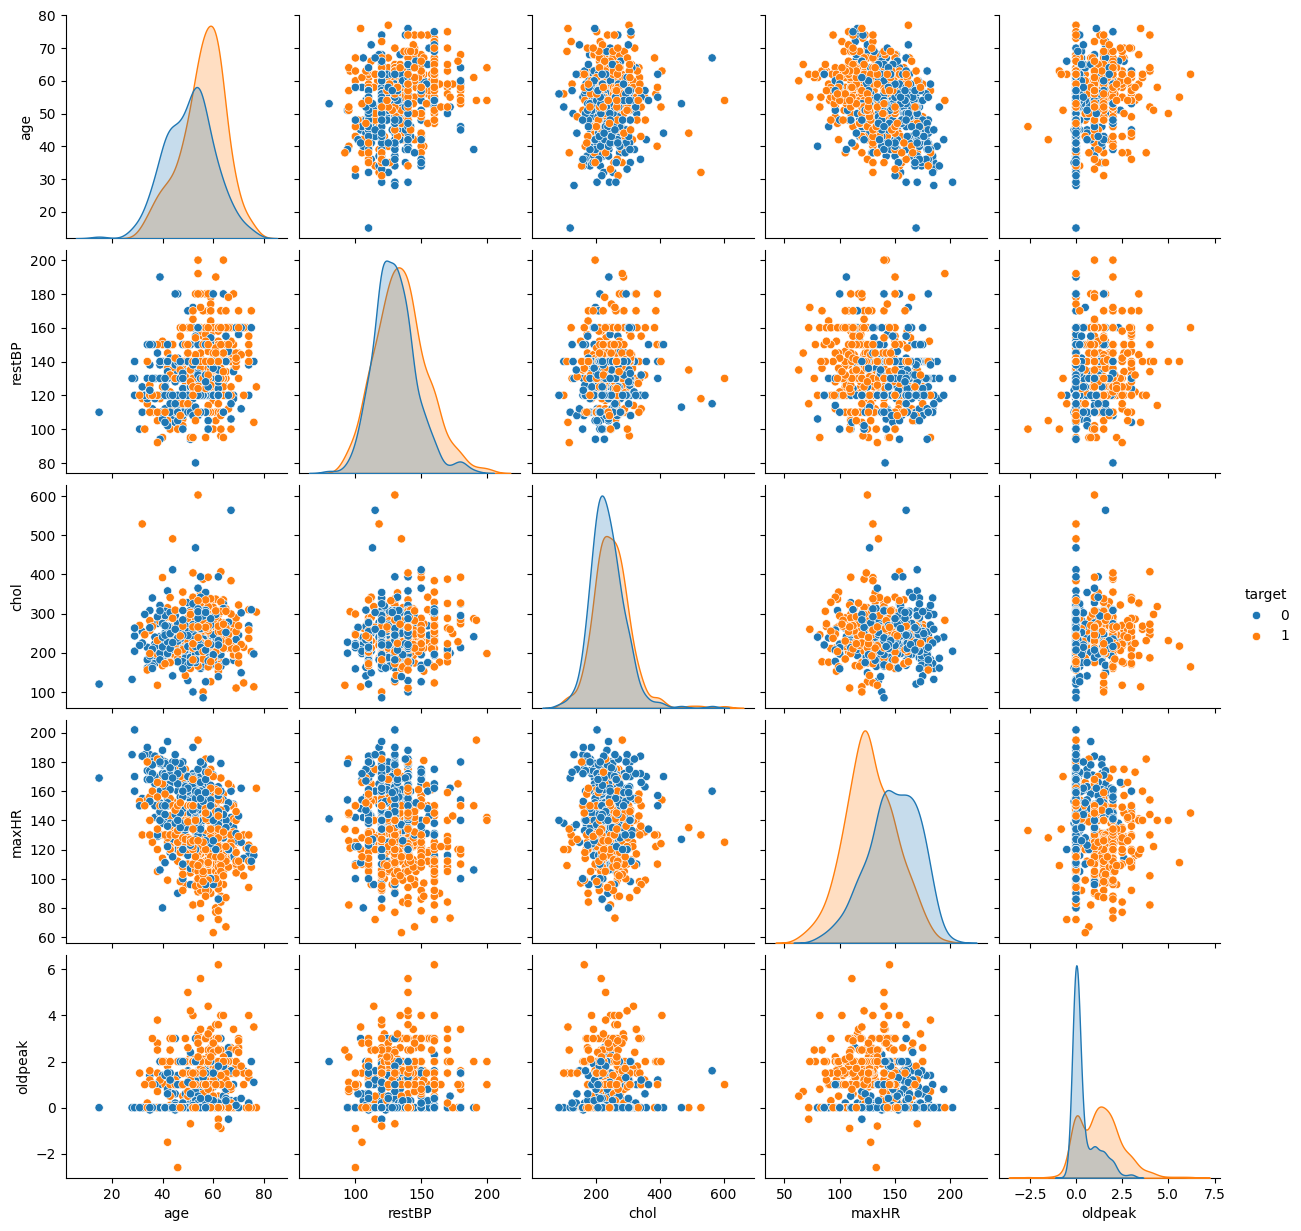

In [ ]:
sns.pairplot(data=Old_data, hue='target');

## QDA and LDA

In [ ]:
qda = QuadraticDiscriminantAnalysis().fit(X_train, y_train)

y_pred_cv = cross_val_predict(qda, X_train, y_train, cv=cv)

cm_qda = confusion_matrix(y_train, y_pred_cv)
accuracy_qda = accuracy_score(y_train, y_pred_cv)
precision_qda = precision_score(y_train, y_pred_cv)
recall_qda = recall_score(y_train, y_pred_cv)
f1_qda = f1_score(y_train, y_pred_cv)
print(cm_qda)



lda = LinearDiscriminantAnalysis().fit(X_train, y_train)
y_pred_cv = cross_val_predict(lda, X_train, y_train, cv=10)

cm_lda = confusion_matrix(y_train, y_pred_cv)
accuracy_lda = accuracy_score(y_train, y_pred_cv)
precision_lda = precision_score(y_train, y_pred_cv)
recall_lda = recall_score(y_train, y_pred_cv)
f1_lda = f1_score(y_train, y_pred_cv)
print(cm_lda)


[[197  35]
 [ 39 224]]
[[196  36]
 [ 29 234]]


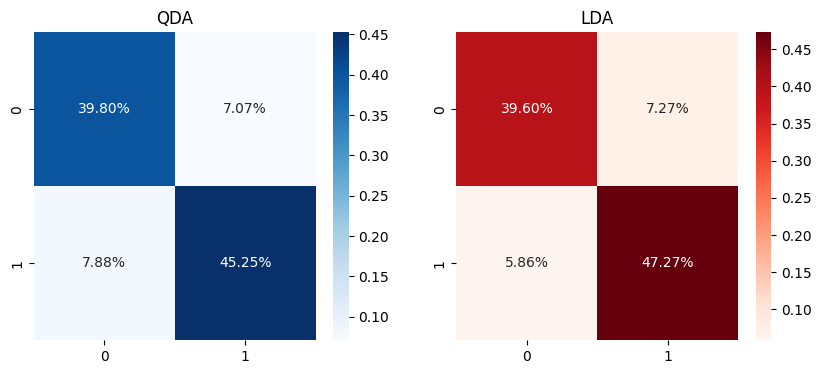

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(cm_qda/np.sum(cm_qda), annot=True, fmt='.2%', cmap='Blues', ax=axs[0]);
axs[0].set_title('QDA');
sns.heatmap(cm_lda/np.sum(cm_lda), annot=True, fmt='.2%', cmap='Reds', ax=axs[1]);
axs[1].set_title('LDA');

With this graphic we see that QDA makes less false negative and false positive. So it seems that QDA works better that LDA.

### LOGISTIC REGRESSION

Now, we train our model (logistic regression)

In [ ]:
y_train = y_train.ravel()
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
y_pred_cv = cross_val_predict(lr_model, X_train, y_train, cv=cv)
cm_lr = confusion_matrix(y_train, y_pred_cv)
accuracy_lr = accuracy_score(y_train, y_pred_cv)
precision_lr = precision_score(y_train, y_pred_cv)
recall_lr = recall_score(y_train, y_pred_cv)
f1_lr= f1_score(y_train, y_pred_cv)

LogisticRegression()

All the metrics of the modelcan be computed from the confusion matrix:

In [ ]:
print('confusion matrix:')
target_names = ['0', '1']
print(pd.DataFrame(data=cm_lr, columns=[f'predicted {c}' for c in target_names], index=[f'true {c}' for c in target_names]))
print()
print(classification_report(y_train, y_pred_cv))

confusion matrix:
        predicted 0  predicted 1
true 0          199           33
true 1           35          228

              precision    recall  f1-score   support

           0       0.85      0.86      0.85       232
           1       0.87      0.87      0.87       263

    accuracy                           0.86       495
   macro avg       0.86      0.86      0.86       495
weighted avg       0.86      0.86      0.86       495



<Figure size 640x480 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver Operating Characteristic (ROC) Curve')

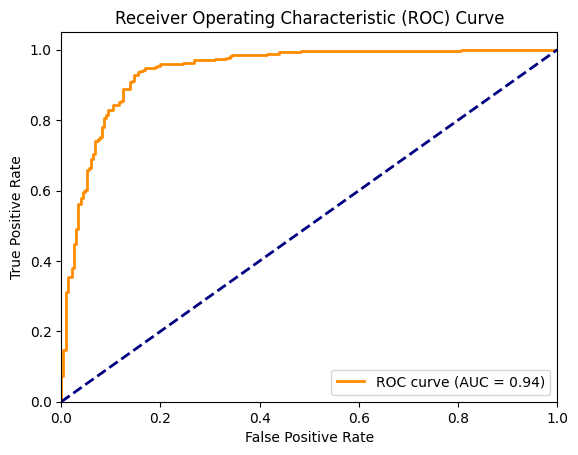

In [ ]:
probs = lr_model.predict_proba(X_train)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_train, probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

With logistic regression we can see better results. With an accuracy and a precision of the 87-88%. Also, the ROC curve is in the upper left corner of the graphic indicating that it's not a "bad" model.

We will test other models and finally choose the one that makes the best predictions.

###DECISION TREE

In [ ]:
def compute_metrics(y_true,y_pred):
    accuracy = accuracy_score(y_true,y_pred)
    f1_score_1 = f1_score(y_true,y_pred,average='binary',pos_label=1)
    f1_score_0 = f1_score(y_true,y_pred,average='binary',pos_label=0)
    f1_score_macro = f1_score(y_true,y_pred,average='macro')
    return [accuracy,f1_score_1,f1_score_0,f1_score_macro]

results = pd.DataFrame(columns=['Accuracy', 'F1-score (class 1)', 'F1-score (class 0)', 'F1-score (macro avg)'])

In [ ]:
model_tree = DecisionTreeClassifier().fit(X_train, y_train)

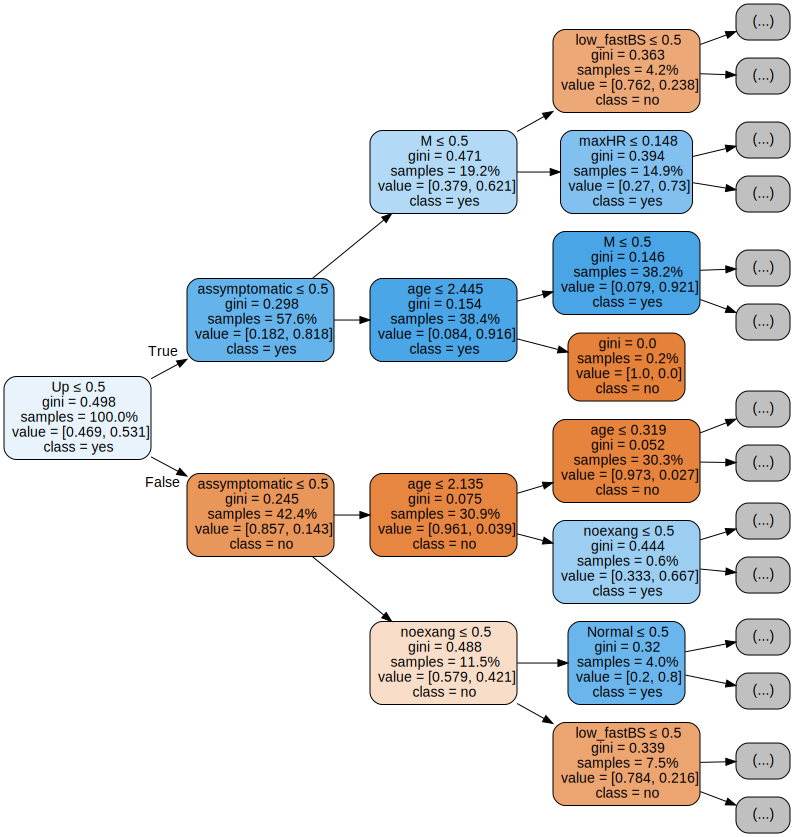

In [ ]:
dot_data = export_graphviz(model_tree, out_file=None,
                         feature_names= ['age','restBP', 'chol', 'maxHR', 'oldpeak','M', 'assymptomatic', 'non_angina', 't_angina', 'low_fastBS', 'Normal', 'ST', 'noexang', 'Flat', 'Up'],
                         class_names=['no', 'yes'],
                         filled=True, rounded=True,
                         special_characters=True,
                         rotate=True,
                         proportion=True,
                         max_depth=3)
graph = graphviz.Source(dot_data)
graph

In [ ]:
y_pred_cv = cross_val_predict(model_tree, X_train, y_train, cv=cv)
results.loc['DT-default',:] = compute_metrics(y_train, y_pred_cv)

confusion_matrix(y_train, y_pred_cv)

array([[188,  44],
       [ 53, 210]])

In [ ]:
print(classification_report(y_train, y_pred_cv, target_names=['no', 'yes'],))
results

              precision    recall  f1-score   support

          no       0.78      0.81      0.79       232
         yes       0.83      0.80      0.81       263

    accuracy                           0.80       495
   macro avg       0.80      0.80      0.80       495
weighted avg       0.80      0.80      0.80       495



Accuracy F1-score (class 1) F1-score (class 0) F1-score (macro avg)
DT-default    0.804              0.812              0.795                0.804

In [ ]:
criterion = ['gini', 'entropy']

max_dephts = [None, 5, 10, 15, 20]
min_samples_split = [2, 3, 4, 5]
min_samples_leaf = [1, 2, 3, 4, 5]
max_features = ['sqrt', 'log2', None]

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

init_time = time()
model_tree = DecisionTreeClassifier()

f1_class_0_scorer = make_scorer(f1_score, pos_label=0)
f1_class_1_scorer = make_scorer(f1_score, pos_label=1)

scoring_dict = {
    'f1_mac': 'f1_macro',
    'f1_class_0': f1_class_0_scorer,
    'f1_class_1': f1_class_1_scorer,
    'acc': 'accuracy'
}

trc = GridSearchCV(estimator=model_tree,
                   scoring=scoring_dict,
                   param_grid={
                       'criterion': criterion,
                       'max_depth': max_dephts,
                       'min_samples_split': min_samples_split,
                       'min_samples_leaf': min_samples_leaf,
                       'max_features': max_features
                   },
                   cv=cv,
                   return_train_score=False,
                   refit='f1_mac')

model_5CV = trc.fit(X_train, y_train)
print(timedelta(seconds=(time() - init_time)))

0:01:06.048749


In [ ]:
scoring_cols = [
    'param_criterion', 'param_max_depth', 'param_max_features',
    'param_min_samples_leaf', 'param_min_samples_split', 'mean_test_f1_mac',
    'mean_test_f1_class_0', 'mean_test_f1_class_1', 'mean_test_acc'
]

pd.DataFrame(model_5CV.cv_results_).sort_values(by='mean_test_f1_mac', ascending=False)[scoring_cols].head()

param_criterion param_max_depth param_max_features  \
72             gini               5               sqrt   
493         entropy              15               sqrt   
196            gini              15               sqrt   
314         entropy            None               sqrt   
408         entropy               5               None   

     param_min_samples_leaf  param_min_samples_split  mean_test_f1_mac  \
72                        4                        2             0.851   
493                       4                        3             0.848   
196                       5                        2             0.846   
314                       4                        4             0.846   
408                       3                        2             0.846   

     mean_test_f1_class_0  mean_test_f1_class_1  mean_test_acc  
72                  0.837                 0.864          0.855  
493                 0.838                 0.859          0.851  
196                 0.836                 0.857          0.849  
314                 0.836                 0.855          0.848  
408                 0.834                 0.857          0.848

In [ ]:
best_params = model_5CV.best_params_
best_params

{'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 2}

In [ ]:
y_pred = model_5CV.predict(X_train)
accuracy_dt = accuracy_score(y_train, y_pred)
precision_dt = precision_score(y_train, y_pred)
recall_dt = recall_score(y_train, y_pred)
f1_dt = f1_score(y_train, y_pred)

results.loc['DT-best',:] = compute_metrics(y_train, y_pred)

confusion_matrix(y_train,y_pred)
results.sort_values(by='F1-score (macro avg)', ascending=False)

array([[193,  39],
       [ 29, 234]])

Accuracy F1-score (class 1) F1-score (class 0) F1-score (macro avg)
DT-best       0.863              0.873               0.85                0.862
DT-default    0.804              0.812              0.795                0.804

Our metrics show that the performance has improven a bit, but not that much. So we will try some model more complex, to find out if we obtain better results.

### RANDOM FORESTS

In [ ]:
y_train = y_train.ravel()
model_rf2 = RandomForestClassifier(n_estimators=100,
                                   oob_score=True,
                                   class_weight='balanced').fit(X_train, y_train)

pred_cv = cross_val_predict(model_rf2, X_train, y_train, cv=cv)

confusion_matrix(y_train, pred_cv)

print(classification_report(y_train,pred_cv,target_names=['no', 'yes'],))

print('OOB accuracy=', model_rf2.oob_score_)

array([[194,  38],
       [ 25, 238]])

              precision    recall  f1-score   support

          no       0.89      0.84      0.86       232
         yes       0.86      0.90      0.88       263

    accuracy                           0.87       495
   macro avg       0.87      0.87      0.87       495
weighted avg       0.87      0.87      0.87       495

OOB accuracy= 0.8767676767676768


In [ ]:
init_time = time()

rf_model = RandomForestClassifier()

ntrees = [200]
max_depth = [100,None]
min_samples_split = [4,6]
min_samples_leaf = [4,6]
balance = [None, 'balanced', 'balanced_subsample']

trc = GridSearchCV(estimator=rf_model,
                   scoring=scoring_dict,
                   param_grid={
                       'n_estimators': ntrees,
                       'max_depth':max_depth,
                       'min_samples_split':min_samples_split,
                       'min_samples_leaf':min_samples_leaf,
                       'class_weight':balance
                   },
                   cv=cv,
                   return_train_score=False,
                   refit=False,
                   n_jobs=-1)

model_5CV = trc.fit(X_train, y_train)
print(timedelta(seconds=(time() - init_time)))

0:01:44.814714


In [ ]:
scoring_cols = [
    'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split',
    'mean_test_f1_mac', 'mean_test_f1_class_0', 'mean_test_f1_class_1',
    'mean_test_acc'
]
pd.DataFrame(model_5CV.cv_results_).sort_values(
    by='mean_test_f1_mac', ascending=False)[scoring_cols].head()

param_max_depth  param_min_samples_leaf  param_min_samples_split  \
23            None                       6                        6   
9              100                       4                        6   
16             100                       4                        4   
8              100                       4                        4   
22            None                       6                        4   

    mean_test_f1_mac  mean_test_f1_class_0  mean_test_f1_class_1  \
23             0.873                 0.859                 0.887   
9              0.872                 0.858                 0.885   
16             0.872                 0.858                 0.885   
8              0.871                 0.858                 0.885   
22             0.868                 0.854                 0.881   

    mean_test_acc  
23          0.877  
9           0.875  
16          0.875  
8           0.875  
22          0.871

In [ ]:
best_params = pd.DataFrame(model_5CV.cv_results_).sort_values(by='mean_test_f1_mac',ascending=False)[['params']].iloc[0,0]
best_params

{'class_weight': 'balanced_subsample',
 'max_depth': None,
 'min_samples_leaf': 6,
 'min_samples_split': 6,
 'n_estimators': 200}

In [ ]:
rf_model_tuned = RandomForestClassifier(**best_params)
rf_model_tuned.fit(X_train, y_train)

y_pred = cross_val_predict(rf_model_tuned, X_train, y_train, cv=cv)
accuracy_rf = accuracy_score(y_train, y_pred)
precision_rf = precision_score(y_train, y_pred)
recall_rf = recall_score(y_train, y_pred)
f1_rf = f1_score(y_train, y_pred)

results.loc['RF-best', :] = compute_metrics(y_train, y_pred)

results.sort_values(by='F1-score (macro avg)', ascending=False)

RandomForestClassifier(class_weight='balanced_subsample', min_samples_leaf=6,
                       min_samples_split=6, n_estimators=200)

Accuracy F1-score (class 1) F1-score (class 0) F1-score (macro avg)
RF-best       0.871              0.882              0.857                0.869
DT-best       0.863              0.873               0.85                0.862
DT-default    0.804              0.812              0.795                0.804

### PERCEPTRON

In [ ]:
perceptron = Perceptron()
perceptron.fit(X_train, y_train)

y_pred_cv = cross_val_predict(perceptron, X_train, y_train, cv=cv)
accuracy_p = accuracy_score(y_train, y_pred_cv)
precision_p = precision_score(y_train, y_pred_cv)
recall_p = recall_score(y_train, y_pred_cv)
f1_p = f1_score(y_train, y_pred_cv)

print(accuracy_p)

Perceptron()

0.795959595959596


## SVM

LinearSVR()

<Axes: >

Kernel  C epsilon     R2    MSE median_absolute_error  \
LinearSVR-default  linear  1       0  0.322  0.166                   0.0   

                  mean_absolute_error  
LinearSVR-default               0.166

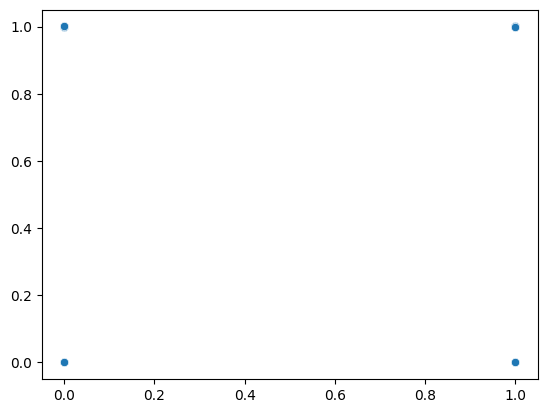

In [ ]:
def comptue_metrics(y_pred, y_real):
    r2 = r2_score(y_pred,y_real)
    mse = mean_squared_error(y_pred, y_real)
    median_abs_e = median_absolute_error(y_pred, y_real)
    mean_abs_e = mean_absolute_error(y_pred, y_real)
    return [r2, mse, median_abs_e, mean_abs_e]

results = pd.DataFrame(columns=['Kernel', 'C', 'epsilon', 'R2', 'MSE', 'median_absolute_error', 'mean_absolute_error'])

y_train = y_train.ravel() if y_train.ndim > 1 else y_train

svm = LinearSVR()

svm.fit(X_train,y_train)
y_pred_cv = cross_val_predict(svm, X_train, y_train, cv=cv)

results.loc['LinearSVR-default', :] = ['linear',1,0] + comptue_metrics(y_pred_cv,y_train)

sns.scatterplot(x=y_train, y=y_pred_cv)

results.sort_values(by='R2', ascending=False)

In [ ]:
cv_5 = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = pd.DataFrame(columns=['Kernel', 'C', 'epsilon', 'R2', 'MSE', 'median_absolute_error', 'mean_absolute_error'])

Cs = [10,20,30,40,50,60]
epsilons = [0.001,0.0001,0.00001,0.000001,0]
for c in Cs:
    for epsilon in epsilons:
        svm = SVR(kernel='linear', C=c,epsilon=epsilon)
        svm.fit(X_train,y_train)
        y_pred = cross_val_predict(svm, X_train, y_train, cv=cv_5)
        cv_results.loc['LinearSVR-{}-{}'.format(c,epsilon), :] = ['linear', c, epsilon] + comptue_metrics(y_pred,y_train)

best = cv_results.sort_values(by='R2',ascending=False).iloc[0,:]
results.loc['LinearSVR-best',:] = best

SVR(C=10, epsilon=0.001, kernel='linear')

SVR(C=10, epsilon=0.0001, kernel='linear')

SVR(C=10, epsilon=1e-05, kernel='linear')

SVR(C=10, epsilon=1e-06, kernel='linear')

SVR(C=10, epsilon=0, kernel='linear')

SVR(C=20, epsilon=0.001, kernel='linear')

SVR(C=20, epsilon=0.0001, kernel='linear')

SVR(C=20, epsilon=1e-05, kernel='linear')

SVR(C=20, epsilon=1e-06, kernel='linear')

SVR(C=20, epsilon=0, kernel='linear')

SVR(C=30, epsilon=0.001, kernel='linear')

SVR(C=30, epsilon=0.0001, kernel='linear')

SVR(C=30, epsilon=1e-05, kernel='linear')

SVR(C=30, epsilon=1e-06, kernel='linear')

SVR(C=30, epsilon=0, kernel='linear')

SVR(C=40, epsilon=0.001, kernel='linear')

SVR(C=40, epsilon=0.0001, kernel='linear')

SVR(C=40, epsilon=1e-05, kernel='linear')

SVR(C=40, epsilon=1e-06, kernel='linear')

SVR(C=40, epsilon=0, kernel='linear')

SVR(C=50, epsilon=0.001, kernel='linear')

SVR(C=50, epsilon=0.0001, kernel='linear')

SVR(C=50, epsilon=1e-05, kernel='linear')

SVR(C=50, epsilon=1e-06, kernel='linear')

SVR(C=50, epsilon=0, kernel='linear')

SVR(C=60, epsilon=0.001, kernel='linear')

SVR(C=60, epsilon=0.0001, kernel='linear')

SVR(C=60, epsilon=1e-05, kernel='linear')

SVR(C=60, epsilon=1e-06, kernel='linear')

SVR(C=60, epsilon=0, kernel='linear')

In [ ]:
cv_results.sort_values(by='R2', ascending=False)

Kernel   C epsilon     R2    MSE median_absolute_error  \
LinearSVR-20-0.001   linear  20   0.001  0.322  0.165                 0.001   
LinearSVR-40-0.001   linear  40   0.001  0.322  0.165                 0.001   
LinearSVR-10-0.001   linear  10   0.001  0.322  0.165                 0.001   
LinearSVR-50-0.001   linear  50   0.001  0.322  0.165                 0.001   
LinearSVR-60-0.001   linear  60   0.001  0.322  0.165                 0.001   
LinearSVR-30-0.001   linear  30   0.001  0.322  0.165                 0.001   
LinearSVR-30-1e-05   linear  30     0.0  0.322  0.166                   0.0   
LinearSVR-20-1e-05   linear  20     0.0  0.322  0.166                   0.0   
LinearSVR-60-1e-06   linear  60     0.0  0.322  0.166                   0.0   
LinearSVR-30-1e-06   linear  30     0.0  0.322  0.166                   0.0   
LinearSVR-60-0.0001  linear  60     0.0  0.322  0.166                   0.0   
LinearSVR-20-1e-06   linear  20     0.0  0.322  0.166                   0.0   
LinearSVR-50-0.0001  linear  50     0.0  0.322  0.166                   0.0   
LinearSVR-30-0       linear  30       0  0.322  0.166                   0.0   
LinearSVR-10-0       linear  10       0  0.322  0.166                   0.0   
LinearSVR-60-1e-05   linear  60     0.0  0.322  0.166                   0.0   
LinearSVR-50-1e-05   linear  50     0.0  0.322  0.166                   0.0   
LinearSVR-10-1e-06   linear  10     0.0  0.322  0.166                   0.0   
LinearSVR-10-0.0001  linear  10     0.0  0.322  0.166                   0.0   
LinearSVR-50-1e-06   linear  50     0.0  0.322  0.166                   0.0   
LinearSVR-40-1e-05   linear  40     0.0  0.322  0.166                   0.0   
LinearSVR-20-0       linear  20       0  0.322  0.166                   0.0   
LinearSVR-50-0       linear  50       0  0.322  0.166                   0.0   
LinearSVR-40-1e-06   linear  40     0.0  0.322  0.166                   0.0   
LinearSVR-40-0.0001  linear  40     0.0  0.322  0.166                   0.0   
LinearSVR-10-1e-05   linear  10     0.0  0.322  0.166                   0.0   
LinearSVR-40-0       linear  40       0  0.322  0.166                   0.0   
LinearSVR-30-0.0001  linear  30     0.0  0.322  0.166                   0.0   
LinearSVR-60-0       linear  60       0  0.322  0.166                   0.0   
LinearSVR-20-0.0001  linear  20     0.0  0.322  0.166                   0.0   

                    mean_absolute_error  
LinearSVR-20-0.001                0.166  
LinearSVR-40-0.001                0.166  
LinearSVR-10-0.001                0.166  
LinearSVR-50-0.001                0.166  
LinearSVR-60-0.001                0.166  
LinearSVR-30-0.001                0.166  
LinearSVR-30-1e-05                0.166  
LinearSVR-20-1e-05                0.166  
LinearSVR-60-1e-06                0.166  
LinearSVR-30-1e-06                0.166  
LinearSVR-60-0.0001               0.166  
LinearSVR-20-1e-06                0.166  
LinearSVR-50-0.0001               0.166  
LinearSVR-30-0                    0.166  
LinearSVR-10-0                    0.166  
LinearSVR-60-1e-05                0.166  
LinearSVR-50-1e-05                0.166  
LinearSVR-10-1e-06                0.166  
LinearSVR-10-0.0001               0.166  
LinearSVR-50-1e-06                0.166  
LinearSVR-40-1e-05                0.166  
LinearSVR-20-0                    0.166  
LinearSVR-50-0                    0.166  
LinearSVR-40-1e-06                0.166  
LinearSVR-40-0.0001               0.166  
LinearSVR-10-1e-05                0.166  
LinearSVR-40-0                    0.166  
LinearSVR-30-0.0001               0.166  
LinearSVR-60-0                    0.166  
LinearSVR-20-0.0001               0.166

In [ ]:
results.sort_values(by='R2', ascending=False)

Kernel   C epsilon     R2    MSE median_absolute_error  \
LinearSVR-best     linear  20   0.001  0.322  0.165                 0.001   
LinearSVR-default  linear   1       0  0.322  0.166                   0.0   

                  mean_absolute_error  
LinearSVR-best                  0.166  
LinearSVR-default               0.166

## NON-LINEAR SVM

SVR()

[-0.07367934  1.0314787   0.87473385  0.97903357  0.77968052  0.37324496
  0.81580243 -0.11541736  0.90800832  0.98681703  0.06657941  0.02618855
  0.28084493  0.89159036 -0.02800375  0.9653654   0.03047153  0.05791361
  0.85979628  0.00447567  1.04743798  0.02330356  0.36185554  0.67645198
  1.16835669  0.13801166  0.39294748  1.20948181 -0.08266988  1.02878389
  0.96667407  1.14692858  0.96183262  0.97170157  1.06454916  0.92941836
 -0.14901849  0.54030348  0.152552    0.99293533 -0.12810466  0.22958046
  0.52506077  0.01847213  0.18452502 -0.04028558  0.06857113  0.90127631
  0.5291356   0.96367329  0.18754769  0.14883967  0.65445509  0.76681022
  1.02205332 -0.05228934  0.71620762  1.01769661  0.76924209  0.07137905
  1.15466101  0.97249344 -0.08925269  0.55361761  0.95694241  1.12415943
  0.94519862  1.13939303  1.03014748  0.48499585  0.44899607  0.67404074
  0.43046216  0.31372506  0.0264789   0.80622539  0.05419997 -0.07029609
  0.23118171  0.45658002  0.01150728  1.03310498  0

<Axes: >

Kernel   C epsilon     R2    MSE median_absolute_error  \
RBF-SVR-default       RBF   1       0  0.386  0.107                 0.134   
LinearSVR-best     linear  20   0.001  0.322  0.165                 0.001   
LinearSVR-default  linear   1       0  0.322  0.166                   0.0   

                  mean_absolute_error  
RBF-SVR-default                  0.22  
LinearSVR-best                  0.166  
LinearSVR-default               0.166

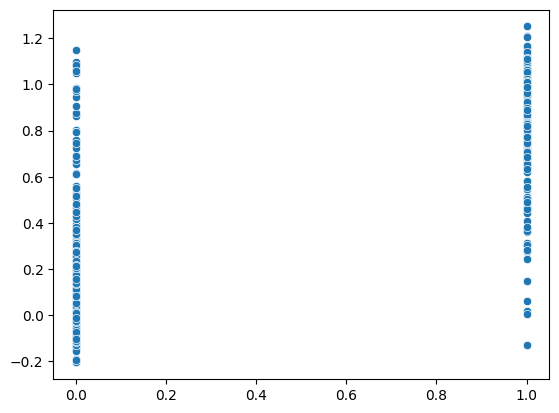

In [ ]:
svr = SVR(kernel='rbf')
svr.fit(X_train,y_train)
y_pred = cross_val_predict(svr, X_train, y_train, cv=cv)
print(y_pred)
results.loc['RBF-SVR-default', :] = ['RBF',1,0]+ comptue_metrics(y_pred,y_train)

sns.scatterplot(x=y_train, y=y_pred)
results.sort_values(by='R2', ascending=False)

In [ ]:
cv_results_rbf = pd.DataFrame(columns=['Kernel', 'C', 'epsilon', 'R2', 'MSE', 'median_absolute_error', 'mean_absolute_error'])

Cs = [10,20,30,40,50,60]
epsilons = [0.001,0.0001,0.00001,0.000001,0]
for c in Cs:
    for epsilon in epsilons:
        svm = SVR(kernel='rbf', C=c,epsilon=epsilon)
        svm.fit(X_train,y_train)
        y_pred = cross_val_predict(svm, X_train, y_train, cv=cv_5)
        cv_results_rbf.loc['RBFSVR-{}-{}'.format(c,epsilon), :] = ['RBF', c, epsilon] + comptue_metrics(y_pred,y_train)

best = cv_results_rbf.sort_values(by='R2',ascending=False).iloc[0,:]
results.loc['RBFSVR-best',:] = best

cv_results_rbf

SVR(C=10, epsilon=0.001)

SVR(C=10, epsilon=0.0001)

SVR(C=10, epsilon=1e-05)

SVR(C=10, epsilon=1e-06)

SVR(C=10, epsilon=0)

SVR(C=20, epsilon=0.001)

SVR(C=20, epsilon=0.0001)

SVR(C=20, epsilon=1e-05)

SVR(C=20, epsilon=1e-06)

SVR(C=20, epsilon=0)

SVR(C=30, epsilon=0.001)

SVR(C=30, epsilon=0.0001)

SVR(C=30, epsilon=1e-05)

SVR(C=30, epsilon=1e-06)

SVR(C=30, epsilon=0)

SVR(C=40, epsilon=0.001)

SVR(C=40, epsilon=0.0001)

SVR(C=40, epsilon=1e-05)

SVR(C=40, epsilon=1e-06)

SVR(C=40, epsilon=0)

SVR(C=50, epsilon=0.001)

SVR(C=50, epsilon=0.0001)

SVR(C=50, epsilon=1e-05)

SVR(C=50, epsilon=1e-06)

SVR(C=50, epsilon=0)

SVR(C=60, epsilon=0.001)

SVR(C=60, epsilon=0.0001)

SVR(C=60, epsilon=1e-05)

SVR(C=60, epsilon=1e-06)

SVR(C=60, epsilon=0)

Kernel   C epsilon     R2    MSE median_absolute_error  \
RBFSVR-10-0.001     RBF  10   0.001  0.332  0.132                 0.122   
RBFSVR-10-0.0001    RBF  10     0.0  0.332  0.132                 0.121   
RBFSVR-10-1e-05     RBF  10     0.0  0.332  0.132                 0.121   
RBFSVR-10-1e-06     RBF  10     0.0  0.332  0.132                 0.121   
RBFSVR-10-0         RBF  10       0  0.332  0.132                 0.121   
RBFSVR-20-0.001     RBF  20   0.001  0.291  0.149                 0.142   
RBFSVR-20-0.0001    RBF  20     0.0  0.292  0.149                 0.144   
RBFSVR-20-1e-05     RBF  20     0.0  0.292  0.149                 0.144   
RBFSVR-20-1e-06     RBF  20     0.0  0.292  0.149                 0.144   
RBFSVR-20-0         RBF  20       0  0.292  0.149                 0.144   
RBFSVR-30-0.001     RBF  30   0.001  0.262  0.162                  0.16   
RBFSVR-30-0.0001    RBF  30     0.0  0.263  0.162                 0.159   
RBFSVR-30-1e-05     RBF  30     0.0  0.263  0.162                 0.159   
RBFSVR-30-1e-06     RBF  30     0.0  0.263  0.162                 0.159   
RBFSVR-30-0         RBF  30       0  0.263  0.162                 0.159   
RBFSVR-40-0.001     RBF  40   0.001  0.249  0.169                 0.168   
RBFSVR-40-0.0001    RBF  40     0.0  0.249  0.169                 0.168   
RBFSVR-40-1e-05     RBF  40     0.0  0.249  0.169                 0.168   
RBFSVR-40-1e-06     RBF  40     0.0  0.249  0.169                 0.168   
RBFSVR-40-0         RBF  40       0  0.249  0.169                 0.168   
RBFSVR-50-0.001     RBF  50   0.001  0.237  0.175                 0.179   
RBFSVR-50-0.0001    RBF  50     0.0  0.237  0.175                 0.179   
RBFSVR-50-1e-05     RBF  50     0.0  0.237  0.175                 0.179   
RBFSVR-50-1e-06     RBF  50     0.0  0.237  0.175                 0.179   
RBFSVR-50-0         RBF  50       0  0.237  0.175                 0.179   
RBFSVR-60-0.001     RBF  60   0.001  0.229   0.18                 0.184   
RBFSVR-60-0.0001    RBF  60     0.0   0.23  0.181                 0.185   
RBFSVR-60-1e-05     RBF  60     0.0   0.23  0.181                 0.185   
RBFSVR-60-1e-06     RBF  60     0.0   0.23  0.181                 0.185   
RBFSVR-60-0         RBF  60       0   0.23  0.181                 0.184   

                 mean_absolute_error  
RBFSVR-10-0.001                0.236  
RBFSVR-10-0.0001               0.236  
RBFSVR-10-1e-05                0.236  
RBFSVR-10-1e-06                0.236  
RBFSVR-10-0                    0.236  
RBFSVR-20-0.001                0.256  
RBFSVR-20-0.0001               0.256  
RBFSVR-20-1e-05                0.256  
RBFSVR-20-1e-06                0.256  
RBFSVR-20-0                    0.256  
RBFSVR-30-0.001                 0.27  
RBFSVR-30-0.0001                0.27  
RBFSVR-30-1e-05                 0.27  
RBFSVR-30-1e-06                 0.27  
RBFSVR-30-0                     0.27  
RBFSVR-40-0.001                0.278  
RBFSVR-40-0.0001               0.278  
RBFSVR-40-1e-05                0.278  
RBFSVR-40-1e-06                0.278  
RBFSVR-40-0                    0.278  
RBFSVR-50-0.001                0.284  
RBFSVR-50-0.0001               0.284  
RBFSVR-50-1e-05                0.284  
RBFSVR-50-1e-06                0.284  
RBFSVR-50-0                    0.284  
RBFSVR-60-0.001                 0.29  
RBFSVR-60-0.0001                0.29  
RBFSVR-60-1e-05                 0.29  
RBFSVR-60-1e-06                 0.29  
RBFSVR-60-0                     0.29

In [ ]:
results.sort_values(by='R2', ascending=False)

Kernel   C epsilon     R2    MSE median_absolute_error  \
RBF-SVR-default       RBF   1       0  0.386  0.107                 0.134   
RBFSVR-best           RBF  10     0.0  0.332  0.132                 0.121   
LinearSVR-best     linear  20   0.001  0.322  0.165                 0.001   
LinearSVR-default  linear   1       0  0.322  0.166                   0.0   

                  mean_absolute_error  
RBF-SVR-default                  0.22  
RBFSVR-best                     0.236  
LinearSVR-best                  0.166  
LinearSVR-default               0.166

## SVM SIGMOID

SVR(kernel='sigmoid')

<Axes: >

Kernel   C epsilon     R2     MSE median_absolute_error  \
RBF-SVR-default         RBF   1       0  0.386   0.107                 0.134   
RBFSVR-best             RBF  10     0.0  0.332   0.132                 0.121   
LinearSVR-best       linear  20   0.001  0.322   0.165                 0.001   
LinearSVR-default    linear   1       0  0.322   0.166                   0.0   
SigmoidSVR-default  Sigmoid   1       0 -0.069  25.792                 2.652   

                   mean_absolute_error  
RBF-SVR-default                   0.22  
RBFSVR-best                      0.236  
LinearSVR-best                   0.166  
LinearSVR-default                0.166  
SigmoidSVR-default               3.714

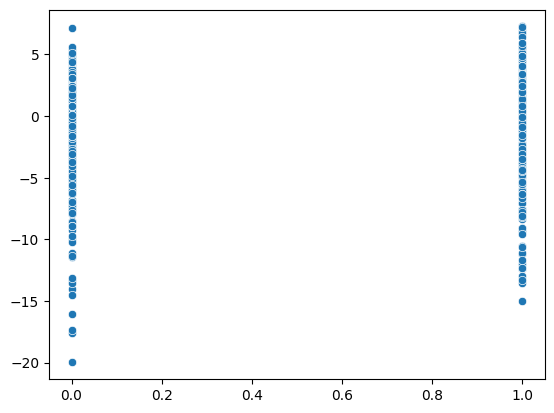

In [ ]:
svr = SVR(kernel='sigmoid')

svr.fit(X_train,y_train)
y_pred = cross_val_predict(svr, X_train, y_train, cv=cv)
results.loc['SigmoidSVR-default', :] = ['Sigmoid',1,0]+ comptue_metrics(y_pred,y_train)

sns.scatterplot(x=y_train, y=y_pred)
results.sort_values(by='R2', ascending=False)

In [ ]:
cv_results_sigmoid = pd.DataFrame(columns=['Kernel', 'C', 'epsilon', 'R2', 'MSE', 'median_absolute_error', 'mean_absolute_error'])

Cs = [10,20,30,40,50,60]
epsilons = [0.001,0.0001,0.00001,0.000001,0]
for c in Cs:
    for epsilon in epsilons:
        svm = SVR(kernel='sigmoid', C=c,epsilon=epsilon)
        svm.fit(X_train,y_train)
        y_pred = cross_val_predict(svm, X_train, y_train, cv=cv_5)
        cv_results_sigmoid.loc['SigmoidSVR-{}-{}'.format(c,epsilon), :] = ['Sigmoid', c, epsilon] + comptue_metrics(y_pred,y_train)

best = cv_results_sigmoid.sort_values(by='R2',ascending=False).iloc[0,:]

results.loc['SigmoidSVR-best',:] = best
results.sort_values(by='R2', ascending=False)

SVR(C=10, epsilon=0.001, kernel='sigmoid')

SVR(C=10, epsilon=0.0001, kernel='sigmoid')

SVR(C=10, epsilon=1e-05, kernel='sigmoid')

SVR(C=10, epsilon=1e-06, kernel='sigmoid')

SVR(C=10, epsilon=0, kernel='sigmoid')

SVR(C=20, epsilon=0.001, kernel='sigmoid')

SVR(C=20, epsilon=0.0001, kernel='sigmoid')

SVR(C=20, epsilon=1e-05, kernel='sigmoid')

SVR(C=20, epsilon=1e-06, kernel='sigmoid')

SVR(C=20, epsilon=0, kernel='sigmoid')

SVR(C=30, epsilon=0.001, kernel='sigmoid')

SVR(C=30, epsilon=0.0001, kernel='sigmoid')

SVR(C=30, epsilon=1e-05, kernel='sigmoid')

SVR(C=30, epsilon=1e-06, kernel='sigmoid')

SVR(C=30, epsilon=0, kernel='sigmoid')

SVR(C=40, epsilon=0.001, kernel='sigmoid')

SVR(C=40, epsilon=0.0001, kernel='sigmoid')

SVR(C=40, epsilon=1e-05, kernel='sigmoid')

SVR(C=40, epsilon=1e-06, kernel='sigmoid')

SVR(C=40, epsilon=0, kernel='sigmoid')

SVR(C=50, epsilon=0.001, kernel='sigmoid')

SVR(C=50, epsilon=0.0001, kernel='sigmoid')

SVR(C=50, epsilon=1e-05, kernel='sigmoid')

SVR(C=50, epsilon=1e-06, kernel='sigmoid')

SVR(C=50, epsilon=0, kernel='sigmoid')

SVR(C=60, epsilon=0.001, kernel='sigmoid')

SVR(C=60, epsilon=0.0001, kernel='sigmoid')

SVR(C=60, epsilon=1e-05, kernel='sigmoid')

SVR(C=60, epsilon=1e-06, kernel='sigmoid')

SVR(C=60, epsilon=0, kernel='sigmoid')

Kernel   C epsilon     R2       MSE  \
RBF-SVR-default         RBF   1       0  0.386     0.107   
RBFSVR-best             RBF  10     0.0  0.332     0.132   
LinearSVR-best       linear  20   0.001  0.322     0.165   
LinearSVR-default    linear   1       0  0.322     0.166   
SigmoidSVR-best     Sigmoid  20   0.001    0.0  8092.849   
SigmoidSVR-default  Sigmoid   1       0 -0.069    25.792   

                   median_absolute_error mean_absolute_error  
RBF-SVR-default                    0.134                0.22  
RBFSVR-best                        0.121               0.236  
LinearSVR-best                     0.001               0.166  
LinearSVR-default                    0.0               0.166  
SigmoidSVR-best                   47.441              65.054  
SigmoidSVR-default                 2.652               3.714

## POLYNOMIAL KERNEL

SVR(kernel='poly')

<Axes: >

Kernel   C epsilon     R2       MSE  \
RBF-SVR-default         RBF   1       0  0.386     0.107   
poly-SVR-default     poly-2   1       0  0.338      0.14   
RBFSVR-best             RBF  10     0.0  0.332     0.132   
LinearSVR-best       linear  20   0.001  0.322     0.165   
LinearSVR-default    linear   1       0  0.322     0.166   
SigmoidSVR-best     Sigmoid  20   0.001    0.0  8092.849   
SigmoidSVR-default  Sigmoid   1       0 -0.069    25.792   

                   median_absolute_error mean_absolute_error  
RBF-SVR-default                    0.134                0.22  
poly-SVR-default                   0.142               0.252  
RBFSVR-best                        0.121               0.236  
LinearSVR-best                     0.001               0.166  
LinearSVR-default                    0.0               0.166  
SigmoidSVR-best                   47.441              65.054  
SigmoidSVR-default                 2.652               3.714

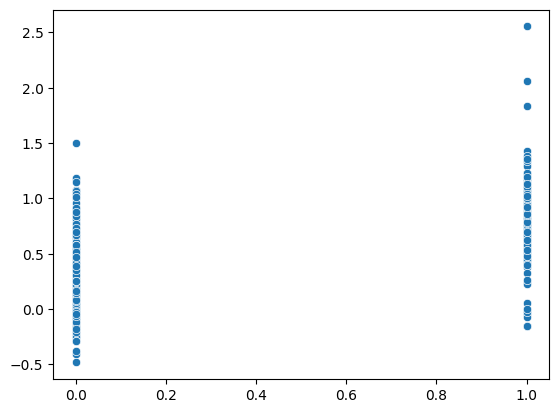

In [ ]:
svr = SVR(kernel='poly')

svr.fit(X_train,y_train)
y_pred = cross_val_predict(svr, X_train, y_train, cv=cv)
results.loc['poly-SVR-default', :] = ['poly-2',1,0]+comptue_metrics(y_pred,y_train)

sns.scatterplot(x=y_train, y=y_pred)
results.sort_values(by='R2', ascending=False)

In [ ]:
cv_results_poly = pd.DataFrame(columns=['Kernel', 'C', 'epsilon', 'R2', 'MSE', 'median_absolute_error', 'mean_absolute_error'])

degrees = [2,3,5]
Cs = [30,40,50]
epsilons = [0.001,0.0001,0.00001,0]
for degree in degrees:
    for c in Cs:
        for epsilon in epsilons:
            svm = SVR(kernel='poly',degree=degree, C=c,epsilon=epsilon)
            svm.fit(X_train,y_train)
            y_pred = svm.predict(X_train)
            cv_results_poly.loc['polySVR-{}-{}-{}'.format(degree,c,epsilon), :] =['poly-{}'.format(degree),c,epsilon] + comptue_metrics(y_pred,y_train)

best = cv_results_poly.sort_values(by='R2',ascending=False).iloc[0,:]
results.loc['polySVR-best',:] = best

results.sort_values(by='R2', ascending=False)

SVR(C=30, degree=2, epsilon=0.001, kernel='poly')

SVR(C=30, degree=2, epsilon=0.0001, kernel='poly')

SVR(C=30, degree=2, epsilon=1e-05, kernel='poly')

SVR(C=30, degree=2, epsilon=0, kernel='poly')

SVR(C=40, degree=2, epsilon=0.001, kernel='poly')

SVR(C=40, degree=2, epsilon=0.0001, kernel='poly')

SVR(C=40, degree=2, epsilon=1e-05, kernel='poly')

SVR(C=40, degree=2, epsilon=0, kernel='poly')

SVR(C=50, degree=2, epsilon=0.001, kernel='poly')

SVR(C=50, degree=2, epsilon=0.0001, kernel='poly')

SVR(C=50, degree=2, epsilon=1e-05, kernel='poly')

SVR(C=50, degree=2, epsilon=0, kernel='poly')

SVR(C=30, epsilon=0.001, kernel='poly')

SVR(C=30, epsilon=0.0001, kernel='poly')

SVR(C=30, epsilon=1e-05, kernel='poly')

SVR(C=30, epsilon=0, kernel='poly')

SVR(C=40, epsilon=0.001, kernel='poly')

SVR(C=40, epsilon=0.0001, kernel='poly')

SVR(C=40, epsilon=1e-05, kernel='poly')

SVR(C=40, epsilon=0, kernel='poly')

SVR(C=50, epsilon=0.001, kernel='poly')

SVR(C=50, epsilon=0.0001, kernel='poly')

SVR(C=50, epsilon=1e-05, kernel='poly')

SVR(C=50, epsilon=0, kernel='poly')

SVR(C=30, degree=5, epsilon=0.001, kernel='poly')

SVR(C=30, degree=5, epsilon=0.0001, kernel='poly')

SVR(C=30, degree=5, epsilon=1e-05, kernel='poly')

SVR(C=30, degree=5, epsilon=0, kernel='poly')

SVR(C=40, degree=5, epsilon=0.001, kernel='poly')

SVR(C=40, degree=5, epsilon=0.0001, kernel='poly')

SVR(C=40, degree=5, epsilon=1e-05, kernel='poly')

SVR(C=40, degree=5, epsilon=0, kernel='poly')

SVR(C=50, degree=5, epsilon=0.001, kernel='poly')

SVR(C=50, degree=5, epsilon=0.0001, kernel='poly')

SVR(C=50, degree=5, epsilon=1e-05, kernel='poly')

SVR(C=50, degree=5, epsilon=0, kernel='poly')

Kernel   C epsilon     R2       MSE  \
polySVR-best         poly-5  50   0.001  0.996     0.001   
RBF-SVR-default         RBF   1       0  0.386     0.107   
poly-SVR-default     poly-2   1       0  0.338      0.14   
RBFSVR-best             RBF  10     0.0  0.332     0.132   
LinearSVR-best       linear  20   0.001  0.322     0.165   
LinearSVR-default    linear   1       0  0.322     0.166   
SigmoidSVR-best     Sigmoid  20   0.001    0.0  8092.849   
SigmoidSVR-default  Sigmoid   1       0 -0.069    25.792   

                   median_absolute_error mean_absolute_error  
polySVR-best                       0.001               0.003  
RBF-SVR-default                    0.134                0.22  
poly-SVR-default                   0.142               0.252  
RBFSVR-best                        0.121               0.236  
LinearSVR-best                     0.001               0.166  
LinearSVR-default                    0.0               0.166  
SigmoidSVR-best                   47.441              65.054  
SigmoidSVR-default                 2.652               3.714

Metrics SVM

In [ ]:
init_time = time()

svm = SVC()

kernels = ['linear', 'rbf', 'poly']
Cs = [0.1, 0.001, 0.5, 1, 2, 3, 4, 5, 6, 0.0001]

trc = GridSearchCV(estimator=svm,
                   param_grid={
                       'C': Cs,
                       'kernel': kernels
                   },
                   scoring=['accuracy', 'recall_macro', 'f1_macro'],
                   cv=cv,
                   return_train_score=True,
                   refit='f1_macro')

model_5CV = trc.fit(X_train, y_train)
print(timedelta(seconds=(time() - init_time)))

model_5CV.best_score_
model_5CV.best_params_

0:00:06.915967


0.8716338018229619

{'C': 0.1, 'kernel': 'linear'}

In [ ]:
pd.DataFrame(model_5CV.cv_results_).loc[:, [
    'mean_fit_time',
    'std_fit_time',
    'param_C',
    'param_kernel',
    'mean_test_accuracy',
    'std_test_accuracy',
    'mean_test_recall_macro',
    'std_test_recall_macro',
    'mean_test_f1_macro',
    'std_test_f1_macro',
]].sort_values(by='mean_test_f1_macro',ascending=False)

mean_fit_time  std_fit_time    param_C param_kernel  mean_test_accuracy  \
0           0.006     7.405e-04  1.000e-01       linear               0.875   
22          0.008     2.378e-04  5.000e+00          rbf               0.871   
16          0.007     5.410e-04  3.000e+00          rbf               0.871   
6           0.005     4.105e-04  5.000e-01       linear               0.869   
18          0.008     2.644e-04  4.000e+00       linear               0.869   
19          0.008     7.932e-04  4.000e+00          rbf               0.869   
25          0.008     2.041e-04  6.000e+00          rbf               0.867   
13          0.007     2.055e-04  2.000e+00          rbf               0.867   
9           0.006     2.854e-04  1.000e+00       linear               0.865   
12          0.007     6.446e-04  2.000e+00       linear               0.865   
10          0.007     1.113e-03  1.000e+00          rbf               0.865   
15          0.008     1.554e-03  3.000e+00       linear               0.863   
24          0.010     7.250e-04  6.000e+00       linear               0.861   
8           0.006     7.236e-04  5.000e-01         poly               0.863   
11          0.006     2.299e-04  1.000e+00         poly               0.861   
7           0.007     7.270e-04  5.000e-01          rbf               0.861   
21          0.009     9.252e-04  5.000e+00       linear               0.857   
1           0.009     8.789e-04  1.000e-01          rbf               0.853   
2           0.008     1.760e-03  1.000e-01         poly               0.851   
20          0.008     2.031e-03  4.000e+00         poly               0.846   
26          0.008     4.184e-04  6.000e+00         poly               0.844   
23          0.008     2.799e-04  5.000e+00         poly               0.840   
17          0.007     2.580e-04  3.000e+00         poly               0.840   
14          0.007     2.907e-04  2.000e+00         poly               0.838   
3           0.008     1.993e-04  1.000e-03       linear               0.721   
5           0.010     1.304e-03  1.000e-03         poly               0.531   
4           0.011     1.795e-04  1.000e-03          rbf               0.531   
27          0.008     8.220e-04  1.000e-04       linear               0.531   
28          0.011     1.240e-03  1.000e-04          rbf               0.531   
29          0.009     2.121e-04  1.000e-04         poly               0.531   

    std_test_accuracy  mean_test_recall_macro  std_test_recall_macro  \
0               0.043                   0.873                  0.046   
22              0.040                   0.870                  0.041   
16              0.038                   0.869                  0.040   
6               0.040                   0.868                  0.041   
18              0.046                   0.867                  0.048   
19              0.042                   0.867                  0.043   
25              0.044                   0.867                  0.045   
13              0.039                   0.864                  0.043   
9               0.038                   0.863                  0.038   
12              0.044                   0.863                  0.045   
10              0.034                   0.862                  0.038   
15              0.044                   0.863                  0.046   
24              0.048                   0.861                  0.049   
8               0.043                   0.858                  0.051   
11              0.060                   0.858                  0.064   
7               0.040                   0.857                  0.045   
21              0.047                   0.855                  0.048   
1               0.052                   0.846                  0.059   
2               0.043                   0.844                  0.052   
20              0.044                   0.845                  0.050   
26              0.047                   0.

In [ ]:
best_model = model_5CV.best_estimator_
y_pred = best_model.predict(X_train)

accuracy_svm = accuracy_score(y_train, y_pred)
precision_svm = precision_score(y_train, y_pred)
recall_svm = recall_score(y_train, y_pred)
f1_svm= f1_score(y_train, y_pred)
conf_matrix = confusion_matrix(y_train, y_pred)

conf_matrix

array([[197,  35],
       [ 21, 242]])

## CLUSTERING

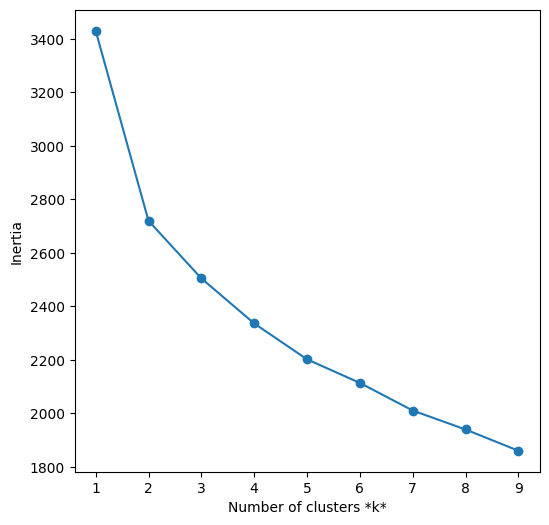

In [ ]:
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X_train)
    sse.append(km.inertia_)

plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Inertia');

In [ ]:
from scipy.stats import mode
index= pd.MultiIndex.from_arrays([[], []], names=('model', 'K'))

results_df3 = pd.DataFrame(index=index, columns=['CH score', 'Silhouette score', 'DB score', 'Precision', 'Recall', 'Accuracy', 'F1 Score'])

for k in [2, 3, 5, 10]:
    kmeans = KMeans(n_clusters=k,max_iter=10000);
    kmeans.fit(X_train);

    CH = calinski_harabasz_score(X_train, kmeans.labels_ );
    S = silhouette_score(X_train, kmeans.labels_ );
    DB = davies_bouldin_score(X_train, kmeans.labels_ );

    labels = kmeans.labels_
    true_labels = y_train  # Replace with your actual true labels

    predicted_labels = cross_val_predict(kmeans, X_train, y_train, cv=cv)

    precision = precision_score(y_train, predicted_labels, average='weighted')
    recall = recall_score(y_train, predicted_labels, average='weighted')
    accuracy = accuracy_score(y_train, predicted_labels)
    f1 = f1_score(y_train, predicted_labels, average='weighted')


    results_df3.loc[('kmeans', k), :] = [CH, S, DB, precision, recall, accuracy, f1]

KMeans(max_iter=10000, n_clusters=2)

KMeans(max_iter=10000, n_clusters=3)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


KMeans(max_iter=10000, n_clusters=5)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


KMeans(max_iter=10000, n_clusters=10)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
results_df3.sort_values(by='CH score', ascending=False)


accuracy_cl = 0.598
precision_cl = 0.601
recall_cl = 0.598
f1_cl = 0.598

CH score Silhouette score DB score Precision Recall Accuracy  \
model  K                                                                 
kmeans 2   129.628            0.189    1.888     0.482  0.481    0.481   
       3    92.206            0.136    2.192     0.476  0.305    0.305   
       5    57.602            0.118    1.808     0.669  0.255    0.255   
       10   46.307            0.096    1.962     0.442  0.093    0.093   

          F1 Score  
model  K            
kmeans 2     0.481  
       3     0.372  
       5     0.368  
       10    0.154

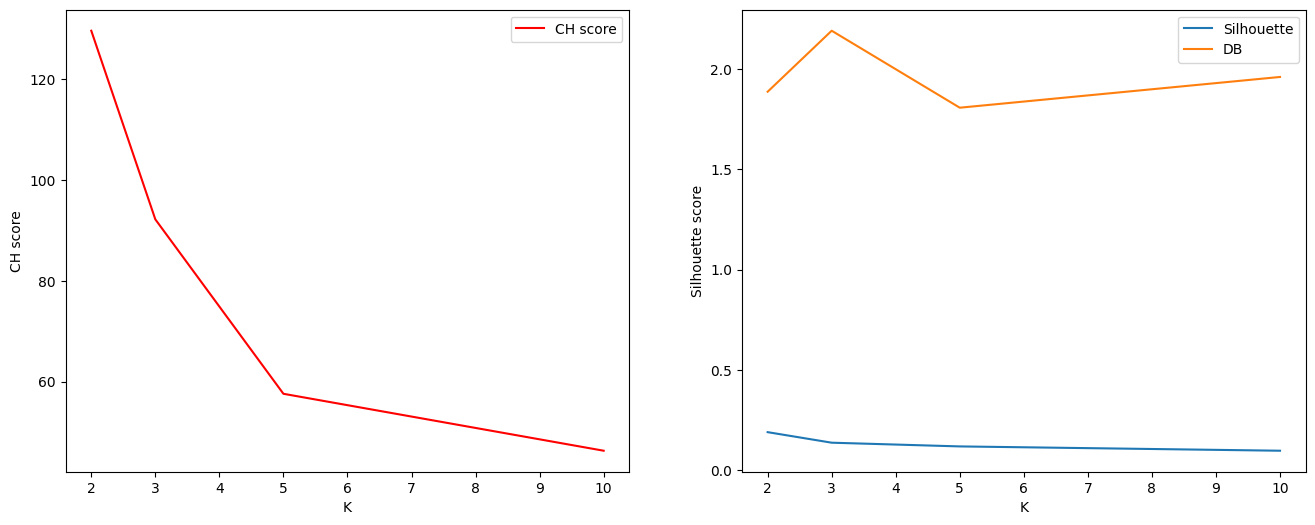

In [ ]:
results_df3 = results_df3.sort_index()
results_df3 = results_df3.astype(float)

fig, ax = plt.subplots(1,2, figsize=(16,6))

sns.lineplot(x='K', y='CH score',data=results_df3.reset_index(),label='CH score', color='r', ax=ax[0]);
sns.lineplot(x='K', y='Silhouette score',data=results_df3.reset_index(),label='Silhouette',ax=ax[1]);
sns.lineplot(x='K', y='DB score',data=results_df3.reset_index(),label='DB');

KMeans(max_iter=10000, n_clusters=2, random_state=42)

<Axes: >

<Axes: >

Text(0.5, 1.0, 'KMeans Clustering (k=2)')

Text(0.5, 0, 'Feature 1')

Text(0, 0.5, 'Feature 2')

(-3.36665081506973, 3.7597376532015856)

(-3.4955218052058052, 2.950196571624634)

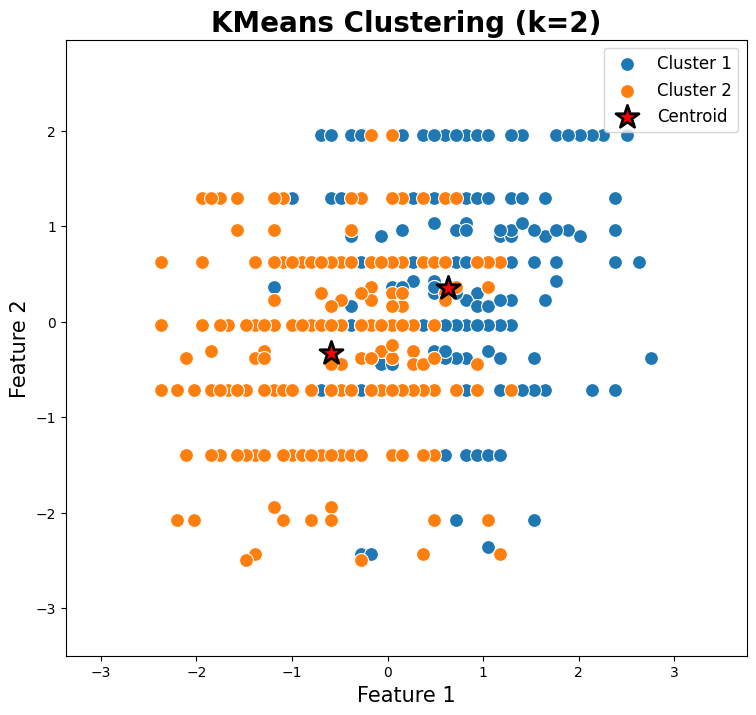

In [ ]:
km = KMeans(n_clusters=2, max_iter=10000, random_state=42)
km.fit(X_train)
centroids = km.cluster_centers_

labels_ = km.labels_

fig, ax = plt.subplots(figsize=(10, 8))

sns.scatterplot(x=X_train[labels_ == 0, 0], y=X_train[labels_ == 0, 1],
                s=100, label='Cluster 1', ax=ax)
sns.scatterplot(x=X_train[labels_ == 1, 0], y=X_train[labels_ == 1, 1],
                s=100, label='Cluster 2', ax=ax)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=300,
            color='red', edgecolor='black', linewidth=2, label='Centroid')

plt.legend(loc='upper right', fontsize=12)
plt.title('KMeans Clustering (k=2)', fontsize=20, fontweight='bold')
plt.xlabel('Feature 1', fontsize=15)
plt.ylabel('Feature 2', fontsize=15)
plt.xlim([X_train[:, 0].min() - 1, X_train[:, 0].max() + 1])
plt.ylim([X_train[:, 1].min() - 1, X_train[:, 1].max() + 1])

ax.set_aspect('equal')

plt.show()

# ALL METRICS

In [ ]:
data = [
    ["LDA",  precision_lda, recall_lda,accuracy_lda, f1_lda],
    ["Logistic Regression", precision_lr, recall_lr, accuracy_lr, f1_lr],
    ["Decision Tree", precision_dt, recall_dt, accuracy_dt, f1_dt],
    ["Random Forest Balance", precision_rf, recall_rf, accuracy_rf, f1_rf],
    ["Perceptron",  precision_p, recall_p, accuracy_p, f1_p],
    ["SVM",  precision_svm, recall_svm, accuracy_svm, f1_svm],
    ["Clustering", precision_cl, recall_cl, accuracy_cl, f1_cl]
]

headers = ['Model','Precision', 'Recall','Accuracy' , 'F1-score']

# Mostrar tabla
print(tabulate(data, headers=headers))

Model                    Precision    Recall    Accuracy    F1-score
---------------------  -----------  --------  ----------  ----------
LDA                       0.866667  0.889734    0.868687    0.878049
Logistic Regression       0.873563  0.86692     0.862626    0.870229
Decision Tree             0.857143  0.889734    0.862626    0.873134
Random Forest Balance     0.854093  0.912548    0.870707    0.882353
Perceptron                0.826613  0.779468    0.79596     0.802348
SVM                       0.873646  0.920152    0.886869    0.896296
Clustering                0.601     0.598       0.598       0.598


# TEST

Once we have choose the best model: Random forest, we will test it.

In [ ]:
feature_columns = ['age','sex', 'cpt','restBP', 'chol', 'fastBS', 'restecg', 'maxHR', 'exang', 'oldpeak', 'slope']
target_column = ['target']
print(X_test)
X_df = pd.DataFrame(X_test, columns=feature_columns)

y_df = pd.DataFrame(y_test, columns=target_column)

test_data = pd.concat([X_df, y_df], axis=1)

test_data.age = test_data.age.astype('int64')
test_data.restBP = test_data.restBP.astype('int64')
test_data.chol = test_data.chol.astype('int64')
test_data.maxHR = test_data.maxHR.astype('int64')
test_data.oldpeak = test_data.oldpeak.astype('float64')

[[55 'M' 'assymptomatic' ... 'noexang' 0.1 'Flat']
 [66 'M' 'assymptomatic' ... 'noexang' 0.4 'Flat']
 [51 'M' 'assymptomatic' ... 'noexang' 0.0 'Flat']
 ...
 [56 'M' 'non_angina' ... 'exang' 2.5 'Flat']
 [60 'M' 'non_angina' ... 'noexang' 2.4 'Up']
 [72 'M' 'assymptomatic' ... 'exang' 1.4 'Flat']]


In [ ]:
Old_test_data = test_data

#Sex
sex = pd.get_dummies(test_data['sex'], drop_first=True)

#Cpt
cpt = pd.get_dummies(test_data['cpt'], drop_first=True)

#FastBS
fastbs = pd.get_dummies(test_data['fastBS'], drop_first=True)

#Restecg
restecg = pd.get_dummies(test_data['restecg'], drop_first=True)

#Exang
exang = pd.get_dummies(test_data['exang'], drop_first=True)

#Slope
slope = pd.get_dummies(test_data['slope'], drop_first=True)


test_data.drop(['sex', 'cpt', 'fastBS', 'restecg', 'exang', 'slope'], axis=1, inplace=True)
test_data = pd.concat([test_data, sex, cpt, fastbs, restecg, exang, slope], axis=1)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            230 non-null    int64  
 1   restBP         230 non-null    int64  
 2   chol           230 non-null    int64  
 3   maxHR          230 non-null    int64  
 4   oldpeak        230 non-null    float64
 5   target         230 non-null    object 
 6   M              230 non-null    bool   
 7   assymptomatic  230 non-null    bool   
 8   non_angina     230 non-null    bool   
 9   t_angina       230 non-null    bool   
 10  low_fastBS     230 non-null    bool   
 11  Normal         230 non-null    bool   
 12  ST             230 non-null    bool   
 13  noexang        230 non-null    bool   
 14  Flat           230 non-null    bool   
 15  Up             230 non-null    bool   
dtypes: bool(10), float64(1), int64(4), object(1)
memory usage: 13.2+ KB


In [ ]:
for x in ['chol', 'age', 'restBP', 'maxHR']:
  test_data = test_data[test_data[x]>0]
  y, _= boxcox(test_data[x])
  y = preprocessing.scale(y)
  test_data[x] = y

test_data['oldpeak'] = preprocessing.scale(test_data['oldpeak'])

# RANDOM FOREST (test)

In [ ]:
X_test = test_data[['age','restBP', 'chol', 'maxHR', 'oldpeak','M', 'assymptomatic', 'non_angina', 't_angina', 'low_fastBS', 'Normal', 'ST', 'noexang', 'Flat', 'Up']].to_numpy()
y_test = test_data[['target']].to_numpy()
y_pred = rf_model_tuned.predict(X_test)

y_test = y_test.astype(np.int64)

accuracy1 = accuracy_score(y_test, y_pred)
precision1 = precision_score(y_test, y_pred)
recall1 = recall_score(y_test, y_pred)
f1_1 = f1_score(y_test, y_pred)
matrix1 = confusion_matrix(y_test, y_pred)

In [ ]:
print(accuracy1, precision1, recall1, f1_1)
matrix1
print('confusion matrix:')
target_names = ['0', '1']
print(pd.DataFrame(data=matrix1, columns=[f'predicted {c}' for c in target_names], index=[f'true {c}' for c in target_names]))
print()

0.8361581920903954 0.8 0.8674698795180723 0.8323699421965318


array([[76, 18],
       [11, 72]])

confusion matrix:
        predicted 0  predicted 1
true 0           76           18
true 1           11           72



# SVM (test)

In [ ]:
y_pred = best_model.predict(X_test)

accuracy2 = accuracy_score(y_test, y_pred)
precision2 = precision_score(y_test, y_pred)
recall2 = recall_score(y_test, y_pred)
f1_2= f1_score(y_test, y_pred)
matrix2 = confusion_matrix(y_test, y_pred)

print(accuracy2, precision2, recall2, f1_2)
matrix2
print('confusion matrix:')
target_names = ['0', '1']
print(pd.DataFrame(data=matrix2, columns=[f'predicted {c}' for c in target_names], index=[f'true {c}' for c in target_names]))
print()

0.8192090395480226 0.7741935483870968 0.8674698795180723 0.8181818181818182


array([[73, 21],
       [11, 72]])

confusion matrix:
        predicted 0  predicted 1
true 0           73           21
true 1           11           72

